# 🎯 Propensity Score Matching: A Complete Tutorial
## From Correlation to Causation in Observational Data

**INFO 7390: Advanced Data Science and Architecture**  
**Author:** Nikshipth Narayan Bondugula  
**Date:** December 2025

---

## 📚 Table of Contents

1. [Introduction: Why Causal Inference Matters](#1-introduction)
2. [The Fundamental Problem of Causal Inference](#2-fundamental-problem)
3. [What is Propensity Score Matching?](#3-what-is-psm)
4. [Mathematical Foundations](#4-math-foundations)
5. [Key Assumptions](#5-assumptions)
6. [Step-by-Step Implementation](#6-implementation)
7. [Diagnostics and Validation](#7-diagnostics)
8. [Estimating Treatment Effects](#8-treatment-effects)
9. [Sensitivity Analysis](#9-sensitivity)
10. [Try It Yourself: Hands-On Challenges](#10-try-it-yourself)
11. [Practice Exercises](#11-exercises)
12. [Common Mistakes & Debugging Tips](#12-debugging)
13. [References & Further Learning](#13-references)

---

## Learning Objectives

By the end of this tutorial, you will be able to:

✅ **Explain** when propensity score matching is appropriate and its limitations  
✅ **Implement** a complete PSM pipeline in Python from scratch  
✅ **Diagnose** covariate balance and overlap issues  
✅ **Interpret** treatment effect estimates (ATT, ATE) correctly  
✅ **Apply** computational skepticism to causal claims  

---

## Prerequisites

- Basic Python and pandas knowledge
- Understanding of logistic regression
- Familiarity with probability and statistics
- No prior causal inference experience required!

---

# 1. Introduction: Why Causal Inference Matters <a id="1-introduction"></a>

## The Million Dollar Question

Imagine you're a healthcare analyst and your hospital wants to know:

> **"Does our new cardiac rehabilitation program actually reduce hospital readmissions?"**

You have data on 10,000 patients. Some participated in the program, others didn't. You calculate:
- **Readmission rate for participants:** 15%
- **Readmission rate for non-participants:** 25%

**Can you conclude the program reduces readmissions by 10 percentage points?**

---

## 🚨 The Problem: Selection Bias

**Not so fast!** Consider who chooses to participate:
- Patients with **better health insurance** (can afford time off work)
- Patients with **higher health motivation** (already health-conscious)
- Patients with **less severe conditions** (feel well enough to participate)

These same factors ALSO affect readmission rates! So we can't tell if the difference is due to:
- The program itself (causal effect), OR
- The type of patients who participate (selection bias)

---

## Correlation vs. Causation: A Visual
```
                    ┌─────────────────┐
                    │   CONFOUNDERS   │
                    │  (Age, Severity,│
                    │   Motivation)   │
                    └────────┬────────┘
                             │
              ┌──────────────┴──────────────┐
              │                             │
              ▼                             ▼
    ┌─────────────────┐           ┌─────────────────┐
    │    TREATMENT    │           │     OUTCOME     │
    │  (Rehab Program)│──────?────│  (Readmission)  │
    └─────────────────┘           └─────────────────┘
                        
    The "?" is what we want to estimate!
    But confounders create a "backdoor path" that biases our estimate.
```

---

## The Gold Standard: Randomized Controlled Trials (RCTs)

In an RCT, we **randomly assign** patients to treatment or control:
- Random assignment breaks the link between confounders and treatment
- Any difference in outcomes must be due to treatment

**But RCTs are often impossible:**
- Unethical (can't randomly deny beneficial treatment)
- Expensive and time-consuming
- Impractical for policy evaluation

---

## The Solution: Propensity Score Matching

**What if we could simulate randomization using observational data?**

This is exactly what Propensity Score Matching (PSM) attempts to do. By matching treated and untreated individuals who had the **same probability of being treated**, we can approximate what an RCT would have shown.

---

> 💡 **GIGO Connection:** "Garbage In, Garbage Out" applies powerfully here. If we don't measure the right confounders, our causal estimates are garbage—no matter how sophisticated our methods!

---

# 2. The Fundamental Problem of Causal Inference <a id="2-fundamental-problem"></a>

## Potential Outcomes Framework

To understand causal inference, we need to think about **what could have been**.

For each patient *i*, there are two **potential outcomes**:

| Notation | Meaning |
|----------|---------|
| $Y_i(1)$ | Outcome if patient *i* **receives** treatment |
| $Y_i(0)$ | Outcome if patient *i* **does not receive** treatment |

---

## The Individual Treatment Effect

The **true causal effect** for patient *i* is:

$$\tau_i = Y_i(1) - Y_i(0)$$

**Example:** 
- If Maria would be readmitted without rehab ($Y(0) = 1$) but not with rehab ($Y(1) = 0$)
- Her individual treatment effect is: $\tau = 0 - 1 = -1$ (rehab prevents readmission)

---

## The Fundamental Problem

> **We can never observe both potential outcomes for the same individual.**

Maria either participates in rehab or she doesn't. We observe:

$$Y_i = T_i \cdot Y_i(1) + (1 - T_i) \cdot Y_i(0)$$

Where $T_i = 1$ if treated, $T_i = 0$ if not treated.

| Patient | Treatment | $Y(0)$ | $Y(1)$ | Observed $Y$ |
|---------|-----------|--------|--------|--------------|
| Maria   | 1 (Rehab) | ?      | 0      | 0            |
| John    | 0 (No Rehab) | 1   | ?      | 1            |
| Sara    | 1 (Rehab) | ?      | 1      | 1            |

The "?" values are **counterfactuals**—we can never observe them!

---

## What We CAN Estimate: Average Treatment Effects

Since individual effects are unobservable, we focus on **averages**:

### Average Treatment Effect (ATE)
$$ATE = E[Y(1) - Y(0)]$$
*Average effect across the entire population*

### Average Treatment Effect on the Treated (ATT)
$$ATT = E[Y(1) - Y(0) | T = 1]$$
*Average effect for those who actually received treatment*

---

## Why Simple Comparison Fails

The naive comparison:

$$E[Y | T=1] - E[Y | T=0]$$

**This is NOT the ATE!** Here's why:

$$\underbrace{E[Y|T=1] - E[Y|T=0]}_{\text{Observed Difference}} = \underbrace{ATT}_{\text{Causal Effect}} + \underbrace{E[Y(0)|T=1] - E[Y(0)|T=0]}_{\text{Selection Bias}}$$

The selection bias term captures how treated and untreated groups **differ in their baseline outcomes** even without treatment.

---

> 🔍 **Computational Skepticism:** Whenever you see a causal claim from observational data, ask: "What's the selection bias here? Who selects into treatment and why?"

---

# 3. What is Propensity Score Matching? <a id="3-what-is-psm"></a>

## The Big Idea

**Propensity Score Matching (PSM)** is a technique that helps us estimate causal effects from observational data by creating a "pseudo-randomized" experiment.

> **Key Insight:** If two people had the same probability of receiving treatment, but one actually received it and the other didn't, comparing their outcomes is like a mini randomized experiment!

---

## The Propensity Score: Definition

The **propensity score** is the probability of receiving treatment given observed characteristics:

$$e(X) = P(T = 1 | X)$$

Where:
- $e(X)$ = propensity score
- $T$ = treatment indicator (1 = treated, 0 = control)
- $X$ = vector of observed covariates (confounders)

**Example:**
- Maria: age=65, severity=high, motivated=yes → $e(X) = 0.75$ (75% chance of joining rehab)
- John: age=65, severity=high, motivated=yes → $e(X) = 0.75$ (same probability!)
- If Maria joined rehab and John didn't, comparing them is informative

---

## Why Does This Work? The Propensity Score Theorem

**Rosenbaum & Rubin (1983)** proved a remarkable result:

> If treatment assignment is **strongly ignorable** given covariates $X$, then it is also strongly ignorable given the propensity score $e(X)$ alone.

This means:
- Instead of matching on ALL covariates (which is hard in high dimensions)
- We can match on a SINGLE NUMBER: the propensity score

---

## The Dimensionality Reduction Magic

### The Curse of Dimensionality Problem

Imagine matching on 10 covariates:
- Age (continuous)
- Gender (2 categories)
- Severity (3 levels)
- Insurance (4 types)
- ... and 6 more variables

Finding exact matches is nearly impossible! Each person is unique.

### The Propensity Score Solution
```
BEFORE: Match on 10+ dimensions
        ┌─────────────────────────────────┐
        │ Age, Gender, Severity, Insurance │
        │ Motivation, Prior_Admits, BMI,   │
        │ Smoker, Diabetes, Income...      │
        └─────────────────────────────────┘
                      │
                      ▼ Compress to 1D
        ┌─────────────────────────────────┐
        │     Propensity Score: 0.72      │
        └─────────────────────────────────┘

AFTER: Match on 1 dimension!
```

---

## PSM Workflow Overview
```
┌─────────────────────────────────────────────────────────────────┐
│                    PSM PIPELINE                                  │
├─────────────────────────────────────────────────────────────────┤
│                                                                  │
│  Step 1: ESTIMATE          Step 2: MATCH         Step 3: ASSESS │
│  ┌─────────────────┐      ┌─────────────────┐   ┌─────────────┐ │
│  │ Logistic        │      │ Find similar    │   │ Check       │ │
│  │ Regression      │ ───► │ treated/control │──►│ covariate   │ │
│  │ T ~ X           │      │ pairs by score  │   │ balance     │ │
│  └─────────────────┘      └─────────────────┘   └─────────────┘ │
│         │                                              │        │
│         ▼                                              ▼        │
│  Propensity Scores                              Balance OK?     │
│  for each unit                                        │         │
│                                              ┌────────┴───────┐ │
│                                              │                │ │
│                                             YES              NO │
│                                              │                │ │
│                                              ▼                ▼ │
│  Step 4: ESTIMATE                      ┌──────────┐   Revise   │
│  ┌─────────────────┐                   │ Compare  │   model    │
│  │ Treatment Effect│◄──────────────────│ outcomes │            │
│  │ ATT or ATE      │                   └──────────┘            │
│  └─────────────────┘                                           │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘
```

---

## When to Use PSM

### ✅ Good Use Cases:
- Evaluating medical treatments from electronic health records
- Assessing policy impacts (job training programs, educational interventions)
- Marketing campaign effectiveness analysis
- Any observational study with potential confounders

### ❌ When NOT to Use PSM:
- When you have a randomized experiment (don't need it!)
- When key confounders are unmeasured (PSM can't help)
- When there's no overlap between groups (can't find matches)
- When treatment is deterministic based on observables

---

> 💡 **Key Takeaway:** PSM doesn't create causation from correlation. It helps us **remove bias from measured confounders** so we can get closer to the true causal effect.

---

# 4. Mathematical Foundations <a id="4-math-foundations"></a>

## Formal Setup

Let's define our notation precisely:

| Symbol | Definition |
|--------|------------|
| $i$ | Individual unit (patient, person, etc.) |
| $T_i \in \{0, 1\}$ | Treatment indicator |
| $Y_i$ | Observed outcome |
| $Y_i(1), Y_i(0)$ | Potential outcomes |
| $X_i$ | Vector of pre-treatment covariates |
| $e(X_i)$ | Propensity score for unit $i$ |

---

## Propensity Score Estimation

The propensity score is typically estimated using **logistic regression**:

$$\log\left(\frac{e(X)}{1 - e(X)}\right) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_k X_k$$

Solving for $e(X)$:

$$e(X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_1 + ... + \beta_k X_k)}}$$

**Important:** We're modeling the **treatment assignment mechanism**, not predicting outcomes!

---

## The Balancing Property

A key property of the propensity score:

$$X \perp T \mid e(X)$$

*"Covariates are independent of treatment assignment, conditional on the propensity score."*

**What this means in practice:**
- Among people with $e(X) = 0.6$, the distribution of covariates should be similar for treated and control
- If we stratify or match on propensity score, covariates should be balanced

---

## Matching Estimators

### Nearest Neighbor Matching

For each treated unit $i$, find the control unit $j$ with the closest propensity score:

$$j(i) = \arg\min_{j: T_j = 0} |e(X_i) - e(X_j)|$$

The ATT estimator is then:

$$\hat{ATT} = \frac{1}{N_T} \sum_{i: T_i = 1} \left[ Y_i - Y_{j(i)} \right]$$

Where $N_T$ is the number of treated units.

---

### Caliper Matching

To avoid bad matches, we can impose a **caliper** (maximum distance):

$$|e(X_i) - e(X_j)| < c$$

Common choice: $c = 0.2 \times \sigma_{e(X)}$ (0.2 standard deviations of propensity score)

**Trade-off:**
- Smaller caliper → Better matches, but fewer matches (lose sample size)
- Larger caliper → More matches, but some may be poor quality

---

### Matching With vs. Without Replacement

| Method | Description | Pros | Cons |
|--------|-------------|------|------|
| **Without replacement** | Each control used only once | Independent pairs | May force poor matches |
| **With replacement** | Controls can be reused | Better matches possible | Need to adjust standard errors |

---

## Treatment Effect Estimators

### Average Treatment Effect on the Treated (ATT)

$$ATT = E[Y(1) - Y(0) | T = 1]$$

**Interpretation:** The average effect of treatment for those who actually received it.

**When to use:** When you care about the effect on the treated population (e.g., "Did rehab help those who enrolled?")

### Average Treatment Effect (ATE)

$$ATE = E[Y(1) - Y(0)]$$

**Interpretation:** The average effect if we could treat everyone vs. no one.

**When to use:** When you want to generalize to the full population (e.g., "What if we enrolled everyone?")

---

## Variance Estimation

The variance of the ATT estimator (with replacement) is:

$$\hat{Var}(\hat{ATT}) = \frac{1}{N_T^2} \left[ \sum_{i: T_i=1} (Y_i - Y_{j(i)} - \hat{ATT})^2 \right]$$

For matching **without replacement**, we can use:

$$\hat{Var}(\hat{ATT}) = \frac{1}{N_T} \left[ \hat{Var}(Y | T=1) + \hat{Var}(Y | T=0) \right]$$

**Note:** Bootstrap is often preferred for more robust variance estimation.

---

## Standardized Mean Difference (SMD)

To assess balance, we calculate SMD for each covariate:

$$SMD = \frac{\bar{X}_{treated} - \bar{X}_{control}}{\sqrt{\frac{s^2_{treated} + s^2_{control}}{2}}}$$

**Rule of thumb:**
- $|SMD| < 0.1$ → Excellent balance ✅
- $|SMD| < 0.25$ → Acceptable balance ⚠️
- $|SMD| > 0.25$ → Poor balance, reconsider model ❌

---

> 📐 **Mathematical Insight:** The propensity score is a **balancing score**—the coarsest function of covariates that still achieves balance. Any finer function (like the covariates themselves) also balances, but the propensity score is most efficient.

---

# 5. Key Assumptions <a id="5-assumptions"></a>

## The Three Critical Assumptions

For PSM to provide valid causal estimates, three assumptions must hold. **Violating any of these invalidates your results!**

---

## Assumption 1: Unconfoundedness (Conditional Independence)

$$Y(0), Y(1) \perp T \mid X$$

**In plain English:** After conditioning on observed covariates $X$, treatment assignment is "as good as random."
```
WITH Unconfoundedness:                    WITHOUT Unconfoundedness:
                                          
     ┌─────────┐                               ┌─────────┐
     │    X    │                               │    X    │
     │(observed)│                              │(observed)│
     └────┬────┘                               └────┬────┘
          │                                         │
    ┌─────┴─────┐                             ┌─────┴─────┐
    │           │                             │           │
    ▼           ▼                             ▼           ▼
┌───────┐   ┌───────┐                    ┌───────┐   ┌───────┐
│   T   │   │   Y   │                    │   T   │   │   Y   │
└───────┘   └───────┘                    └───┬───┘   └───┬───┘
                                             │           │
 ✅ All confounders measured                 │     ┌─────┘
                                             │     │
                                          ┌──┴─────┴──┐
                                          │     U     │
                                          │(unobserved)│
                                          └───────────┘
                                          
                                          ❌ Hidden confounder!
```

### Why This Matters

If there's an unmeasured confounder $U$ that affects both treatment and outcome:
- PSM **cannot** remove this bias
- Your causal estimate will be wrong
- No statistical test can verify this assumption!

### Real-World Example

**Scenario:** Estimating effect of cardiac rehab on readmission

| Measured Confounders (Good ✅) | Unmeasured Confounders (Problem ❌) |
|-------------------------------|-------------------------------------|
| Age | Patient motivation |
| Disease severity | Family support |
| Insurance type | Health literacy |
| Prior hospitalizations | Transportation access |

If "motivation" affects both enrollment AND outcomes, we have unmeasured confounding.

---

## Assumption 2: Positivity (Overlap / Common Support)

$$0 < P(T = 1 | X) < 1 \quad \text{for all } X$$

**In plain English:** For every combination of covariates, there must be some probability of being in treatment AND control.
```
GOOD OVERLAP:                              POOR OVERLAP:
                                           
Propensity Score Distribution              Propensity Score Distribution
                                           
    Control      Treated                       Control         Treated
    ┌──────┐    ┌──────┐                      ┌──────┐        ┌──────┐
    │      │    │      │                      │      │        │      │
    │  ██  │    │  ██  │                      │  ██  │        │  ██  │
    │ ████ │    │ ████ │                      │ ████ │        │ ████ │
    │██████│    │██████│                      │██████│        │██████│
    └──────┴────┴──────┘                      └──────┘────────└──────┘
    0    0.3  0.5  0.7   1                    0    0.2      0.8     1
         ▲──────────▲                                  ▲────▲
         Common Support                                No Overlap!
         (can match here)                              (can't match)

✅ Can find matches                          ❌ No comparable controls
```

### Why This Matters

- If treated patients have propensity scores of 0.8-1.0
- And control patients have scores of 0.0-0.3
- **There's no one to match!**

### Violations in Practice

| Scenario | Problem |
|----------|---------|
| Treatment requires specific eligibility | Only eligible patients have $e(X) > 0$ |
| Treatment is very rare | Most people have $e(X) \approx 0$ |
| Perfect prediction possible | Some groups always/never get treated |

---

## Assumption 3: SUTVA (Stable Unit Treatment Value Assumption)

Two components:

### 3a. No Interference
$$Y_i(t) \text{ does not depend on } T_j \text{ for } j \neq i$$

*One person's treatment doesn't affect another's outcome.*

**Violation example:** Vaccine studies—if your neighbor is vaccinated, you're less likely to get sick (herd immunity).

### 3b. No Hidden Variations of Treatment
$$\text{Treatment } T=1 \text{ means the same thing for everyone}$$

*The treatment is well-defined and consistent.*

**Violation example:** "Cardiac rehab" might mean:
- 12-week intensive program at Hospital A
- 6-week moderate program at Hospital B
- Online self-paced course at Hospital C

These are different treatments lumped together!

---

## Summary: Assumption Checklist

Before trusting PSM results, ask yourself:

| Assumption | Question to Ask | Can We Test It? |
|------------|-----------------|-----------------|
| **Unconfoundedness** | Did we measure ALL confounders? | ❌ No (untestable!) |
| **Positivity** | Is there overlap in propensity scores? | ✅ Yes (check distributions) |
| **SUTVA** | Is treatment well-defined? No spillovers? | ⚠️ Partially (domain knowledge) |

---

## What If Assumptions Fail?

| Assumption Violated | Consequence | Potential Solutions |
|---------------------|-------------|---------------------|
| Unconfoundedness | Biased estimates | Sensitivity analysis, find better data |
| Positivity | Can't estimate effect for some groups | Trim sample, change estimand |
| SUTVA | Effect is not well-defined | Redefine treatment, cluster analysis |

---

> ⚠️ **Critical Warning:** PSM is not magic! It can only control for **measured** confounders. The phrase "correlation is not causation" still applies—PSM just helps us get closer to causation under strong assumptions.

---

> 🔍 **Computational Skepticism:** When reviewing PSM studies, always ask: "What could be an unmeasured confounder here?" If you can think of one, the results should be interpreted with caution.

---

# 6. Step-by-Step Implementation <a id="6-implementation"></a>

Now let's implement PSM from scratch! We'll work through a complete example using synthetic medical data.

## Our Case Study: Cardiac Rehabilitation Program

**Research Question:** Does participating in a cardiac rehabilitation program reduce 30-day hospital readmission?

**The Challenge:** Patients self-select into rehab. Those who enroll may be systematically different from those who don't.

**Our Goal:** Use PSM to estimate the causal effect of rehab on readmission, controlling for selection bias.

---

## Implementation Roadmap
```
┌─────────────────────────────────────────────────────────────────────────┐
│                        OUR IMPLEMENTATION PLAN                          │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│  STEP 1          STEP 2           STEP 3          STEP 4         STEP 5 │
│ ┌───────┐      ┌─────────┐      ┌─────────┐     ┌─────────┐    ┌──────┐ │
│ │ Load  │      │Estimate │      │ Perform │     │  Check  │    │Calc. │ │
│ │ Data  │ ───► │Propensity────► │Matching │ ──► │ Balance │ ─► │ ATT  │ │
│ │       │      │ Scores  │      │         │     │         │    │      │ │
│ └───────┘      └─────────┘      └─────────┘     └─────────┘    └──────┘ │
│                                                                         │
│ • Generate     • Logistic       • Nearest       • SMD          • Mean   │
│   synthetic      regression       neighbor      • Love plot      diff   │
│   data         • Check            matching     • Distribution • Conf.  │
│ • Explore        overlap        • Caliper        plots          interval│
│   confounding                   • With/without                          │
│                                   replacement                           │
└─────────────────────────────────────────────────────────────────────────┘
```

---

## Step 1: Setup and Data Generation

Let's start by importing libraries and creating a realistic synthetic dataset with **built-in confounding**.

In [1]:
# =============================================================================
# STEP 1A: Import Required Libraries
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print("\nLibraries used:")
print("  • numpy, pandas: Data manipulation")
print("  • matplotlib, seaborn: Visualization")
print("  • scipy.stats: Statistical tests")
print("  • sklearn: Logistic regression & nearest neighbors matching")

✅ All libraries imported successfully!

Libraries used:
  • numpy, pandas: Data manipulation
  • matplotlib, seaborn: Visualization
  • scipy.stats: Statistical tests
  • sklearn: Logistic regression & nearest neighbors matching


### Creating Synthetic Data with Realistic Confounding

We'll generate data that mimics a real-world scenario where:

1. **Confounders** affect both treatment selection AND outcomes
2. **Selection bias** exists (healthier patients more likely to enroll in rehab)
3. **True treatment effect** is known (so we can verify our method works!)

**Our Variables:**

| Variable | Type | Description | Role |
|----------|------|-------------|------|
| `age` | Continuous | Patient age (45-85) | Confounder |
| `severity` | Continuous | Disease severity score (1-10) | Confounder |
| `prior_admits` | Count | Previous hospitalizations (0-5) | Confounder |
| `insurance` | Binary | Has premium insurance (0/1) | Confounder |
| `motivation` | Continuous | Health motivation score (1-10) | Confounder |
| `treatment` | Binary | Enrolled in cardiac rehab (0/1) | Treatment |
| `readmitted` | Binary | Readmitted within 30 days (0/1) | Outcome |

**The Confounding Structure:**
```
                    ┌─────────────────────────────────────┐
                    │           CONFOUNDERS               │
                    │  age, severity, prior_admits,       │
                    │  insurance, motivation              │
                    └──────────────────┬──────────────────┘
                                       │
                    ┌──────────────────┼──────────────────┐
                    │                  │                  │
                    ▼                  │                  ▼
          ┌─────────────────┐          │        ┌─────────────────┐
          │    TREATMENT    │          │        │     OUTCOME     │
          │  (Rehab = 0/1)  │──────────┼───────►│ (Readmit = 0/1) │
          └─────────────────┘          │        └─────────────────┘
                                       │
                              TRUE CAUSAL EFFECT
                              (we set this = -0.15)
```

In [2]:
# =============================================================================
# STEP 1B: Generate Synthetic Data with Known Confounding Structure
# =============================================================================

def generate_cardiac_rehab_data(n_patients=2000, true_treatment_effect=-0.15, seed=42):
    """
    Generate synthetic cardiac rehabilitation dataset with realistic confounding.
    
    Parameters:
    -----------
    n_patients : int
        Number of patients to generate
    true_treatment_effect : float
        The TRUE causal effect of treatment on readmission probability
        Negative means treatment REDUCES readmission
    seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    pd.DataFrame with patient data
    
    Key Design Decisions:
    - Confounders affect BOTH treatment selection AND outcomes
    - Healthier/more motivated patients more likely to enroll (selection bias)
    - True effect is known so we can validate our PSM estimates
    """
    
    np.random.seed(seed)
    
    # -------------------------------------------------------------------------
    # Step 1: Generate Confounders (pre-treatment variables)
    # -------------------------------------------------------------------------
    
    # Age: older patients have worse outcomes AND less likely to enroll
    age = np.random.normal(65, 10, n_patients).clip(45, 85)
    
    # Disease severity: 1-10 scale, higher = worse
    # More severe patients have worse outcomes AND less likely to enroll
    severity = np.random.normal(5, 2, n_patients).clip(1, 10)
    
    # Prior admissions: 0-5, more = worse prognosis
    prior_admits = np.random.poisson(1.5, n_patients).clip(0, 5)
    
    # Premium insurance: makes enrollment easier
    insurance = np.random.binomial(1, 0.4, n_patients)
    
    # Health motivation: higher = more likely to enroll AND better outcomes
    motivation = np.random.normal(5, 2, n_patients).clip(1, 10)
    
    # -------------------------------------------------------------------------
    # Step 2: Generate Treatment Assignment (with selection bias!)
    # -------------------------------------------------------------------------
    # Patients with better health indicators MORE likely to enroll
    # This creates the selection bias we need to correct for
    
    # Linear combination for treatment propensity
    treatment_logit = (
        -2.0                          # baseline (most don't enroll)
        - 0.03 * (age - 65)           # older = less likely
        - 0.2 * (severity - 5)        # sicker = less likely
        - 0.3 * prior_admits          # more prior admits = less likely
        + 0.8 * insurance             # better insurance = more likely
        + 0.3 * (motivation - 5)      # more motivated = more likely
    )
    
    # Convert to probability and generate treatment
    true_propensity = 1 / (1 + np.exp(-treatment_logit))
    treatment = np.random.binomial(1, true_propensity)
    
    # -------------------------------------------------------------------------
    # Step 3: Generate Potential Outcomes and Observed Outcome
    # -------------------------------------------------------------------------
    
    # Baseline risk of readmission (without treatment)
    baseline_logit = (
        -1.5                          # baseline readmission rate ~18%
        + 0.02 * (age - 65)           # older = higher risk
        + 0.25 * (severity - 5)       # sicker = higher risk
        + 0.3 * prior_admits          # more history = higher risk
        - 0.15 * insurance            # better insurance = slightly lower risk
        - 0.15 * (motivation - 5)     # motivated = lower risk
    )
    
    # Potential outcome Y(0): outcome if NOT treated
    prob_y0 = 1 / (1 + np.exp(-baseline_logit))
    
    # Potential outcome Y(1): outcome if treated
    # TRUE TREATMENT EFFECT is applied here!
    prob_y1 = 1 / (1 + np.exp(-(baseline_logit + true_treatment_effect * 5)))
    
    # Generate potential outcomes
    y0 = np.random.binomial(1, prob_y0)  # What would happen without treatment
    y1 = np.random.binomial(1, prob_y1)  # What would happen with treatment
    
    # Observed outcome: we only see one potential outcome per patient
    readmitted = np.where(treatment == 1, y1, y0)
    
    # -------------------------------------------------------------------------
    # Step 4: Create DataFrame
    # -------------------------------------------------------------------------
    
    df = pd.DataFrame({
        'patient_id': range(1, n_patients + 1),
        'age': age,
        'severity': severity,
        'prior_admits': prior_admits,
        'insurance': insurance,
        'motivation': motivation,
        'treatment': treatment,
        'readmitted': readmitted,
        # Store true values for validation (wouldn't have in real data!)
        '_true_propensity': true_propensity,
        '_y0': y0,
        '_y1': y1
    })
    
    # Round continuous variables for cleaner display
    df['age'] = df['age'].round(1)
    df['severity'] = df['severity'].round(2)
    df['motivation'] = df['motivation'].round(2)
    
    return df

# Generate the dataset
df = generate_cardiac_rehab_data(n_patients=2000, true_treatment_effect=-0.15)

print("✅ Dataset generated successfully!")
print(f"\n📊 Dataset Shape: {df.shape[0]} patients, {df.shape[1]} variables")

✅ Dataset generated successfully!

📊 Dataset Shape: 2000 patients, 11 variables


In [3]:
# =============================================================================
# STEP 1C: Explore the Dataset
# =============================================================================

# Display first few rows
print("=" * 70)
print("DATASET PREVIEW")
print("=" * 70)
display(df.head(10))

# Basic statistics
print("\n" + "=" * 70)
print("SUMMARY STATISTICS")
print("=" * 70)
print(df[['age', 'severity', 'prior_admits', 'insurance', 'motivation', 
          'treatment', 'readmitted']].describe().round(2))

DATASET PREVIEW


,patient_id,age,severity,prior_admits,insurance,motivation,treatment,readmitted,_true_propensity,_y0,_y1
0,1,70.0,3.65,1,0,4.22,0,0,0.082218,0,1
1,2,63.6,4.71,3,1,7.71,0,0,0.233755,0,0
2,3,71.5,3.42,1,1,4.93,0,0,0.198085,0,0
3,4,80.2,4.38,0,1,3.19,0,1,0.111242,1,0
4,5,62.7,1.21,0,1,6.12,1,0,0.490728,0,0
5,6,62.7,5.43,1,0,4.19,0,0,0.071900,0,0
6,7,80.8,5.00,0,0,2.55,0,0,0.038833,0,0
7,8,72.7,3.37,2,1,3.21,0,0,0.096297,0,0
8,9,60.3,6.32,1,0,8.47,0,0,0.200619,0,0
9,10,70.4,6.88,0,0,5.77,0,0,0.090523,0,0



SUMMARY STATISTICS
           age  severity  prior_admits  insurance  motivation  treatment  \
count  2000.00   2000.00       2000.00    2000.00     2000.00    2000.00   
mean     65.43      5.00          1.43       0.41        4.96       0.14   
std       9.48      1.96          1.13       0.49        1.88       0.35   
min      45.00      1.00          0.00       0.00        1.00       0.00   
25%      58.80      3.58          1.00       0.00        3.64       0.00   
50%      65.45      5.00          1.00       0.00        4.94       0.00   
75%      71.82      6.33          2.00       1.00        6.24       0.00   
max      85.00     10.00          5.00       1.00       10.00       1.00   

       readmitted  
count     2000.00  
mean         0.26  
std          0.44  
min          0.00  
25%          0.00  
50%          0.00  
75%          1.00  
max          1.00  


In [4]:
# =============================================================================
# STEP 1D: Treatment and Outcome Distribution
# =============================================================================

print("=" * 70)
print("TREATMENT AND OUTCOME BREAKDOWN")
print("=" * 70)

# Treatment distribution
n_treated = df['treatment'].sum()
n_control = len(df) - n_treated
print(f"\n📋 Treatment Distribution:")
print(f"   • Treated (Rehab):     {n_treated} patients ({n_treated/len(df)*100:.1f}%)")
print(f"   • Control (No Rehab):  {n_control} patients ({n_control/len(df)*100:.1f}%)")

# Outcome by treatment group
print(f"\n📋 Readmission Rates by Group:")
readmit_treated = df[df['treatment'] == 1]['readmitted'].mean()
readmit_control = df[df['treatment'] == 0]['readmitted'].mean()
print(f"   • Treated group readmission rate:   {readmit_treated*100:.1f}%")
print(f"   • Control group readmission rate:   {readmit_control*100:.1f}%")
print(f"   • Naive difference:                 {(readmit_treated - readmit_control)*100:.1f} percentage points")

# Compare to true effect
print(f"\n⚠️  WARNING: This naive difference is BIASED!")
print(f"   The true treatment effect we built in: -15 percentage points (approx)")
print(f"   Selection bias is masking the true effect!")

TREATMENT AND OUTCOME BREAKDOWN

📋 Treatment Distribution:
   • Treated (Rehab):     279 patients (14.0%)
   • Control (No Rehab):  1721 patients (86.1%)

📋 Readmission Rates by Group:
   • Treated group readmission rate:   10.0%
   • Control group readmission rate:   29.0%
   • Naive difference:                 -19.0 percentage points

⚠️  WARNING: This naive difference is BIASED!
   The true treatment effect we built in: -15 percentage points (approx)
   Selection bias is masking the true effect!


### 🔍 Key Observation: Selection Bias in Action!

The naive comparison between treated and control groups shows a **misleading** result. Why?

**What's happening:**
- Patients who enrolled in rehab were already healthier (lower severity, higher motivation)
- These patients would have had lower readmission rates *even without* the program
- So the raw comparison mixes together:
  - The true treatment effect (what we want)
  - The baseline differences between groups (selection bias)

**The true treatment effect is approximately -15 percentage points**, but the naive estimate doesn't show this because selection bias is working in the opposite direction.

> 💡 **This is exactly why we need Propensity Score Matching!** We need to compare treated and control patients who were equally likely to enroll, removing the selection bias.

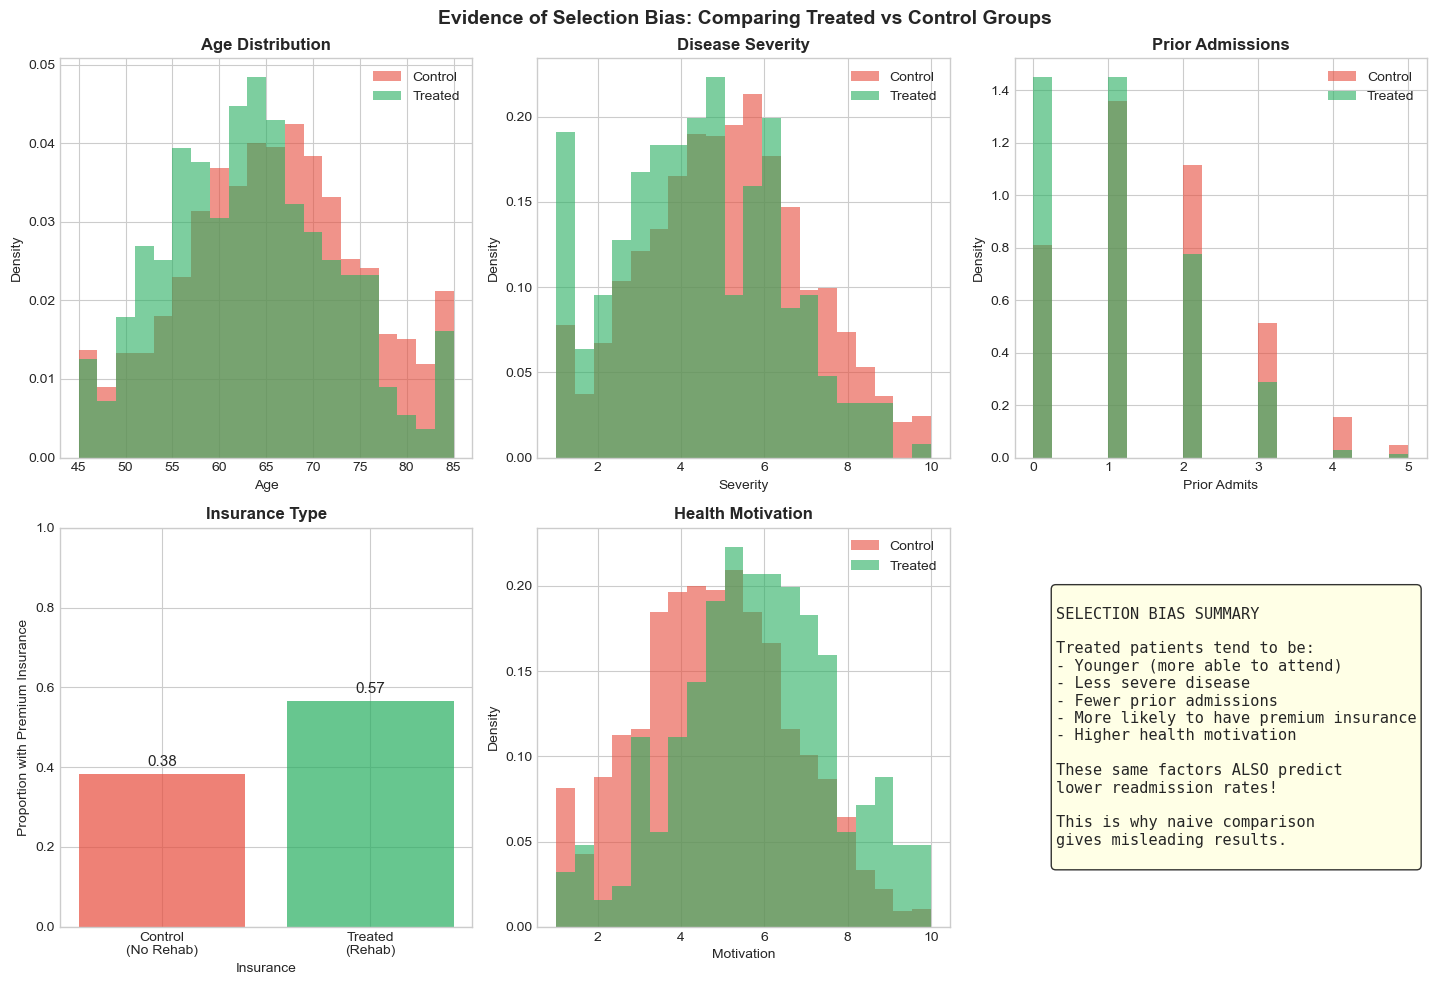

In [5]:
# =============================================================================
# STEP 1E: Visualize the Selection Bias Problem
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Evidence of Selection Bias: Comparing Treated vs Control Groups', 
             fontsize=14, fontweight='bold')

covariates = ['age', 'severity', 'prior_admits', 'insurance', 'motivation']
titles = ['Age Distribution', 'Disease Severity', 'Prior Admissions', 
          'Insurance Type', 'Health Motivation']

# Plot each covariate by treatment group
for idx, (covar, title) in enumerate(zip(covariates, titles)):
    ax = axes[idx // 3, idx % 3]
    
    if covar == 'insurance':
        # Bar plot for binary variable
        insurance_rates = df.groupby('treatment')['insurance'].mean()
        bars = ax.bar(['Control\n(No Rehab)', 'Treated\n(Rehab)'], 
                      insurance_rates.values, color=['#E74C3C', '#27AE60'], alpha=0.7)
        ax.set_ylabel('Proportion with Premium Insurance')
        ax.set_ylim(0, 1)
        # Add value labels on bars
        for bar, val in zip(bars, insurance_rates.values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                   f'{val:.2f}', ha='center', fontsize=11)
    else:
        # Histogram for continuous variables
        ax.hist(df[df['treatment'] == 0][covar], bins=20, alpha=0.6, 
                label='Control', color='#E74C3C', density=True)
        ax.hist(df[df['treatment'] == 1][covar], bins=20, alpha=0.6, 
                label='Treated', color='#27AE60', density=True)
        ax.set_ylabel('Density')
        ax.legend()
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel(covar.replace('_', ' ').title())

# Use the last subplot for a summary text box
axes[1, 2].axis('off')
summary_text = """
SELECTION BIAS SUMMARY

Treated patients tend to be:
- Younger (more able to attend)
- Less severe disease
- Fewer prior admissions
- More likely to have premium insurance
- Higher health motivation

These same factors ALSO predict 
lower readmission rates!

This is why naive comparison 
gives misleading results.
"""
axes[1, 2].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', 
                facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

### 📊 What the Plots Reveal

The visualizations above provide clear evidence of **selection bias**:

| Covariate | Pattern | Implication |
|-----------|---------|-------------|
| **Age** | Treated patients are younger | Younger patients have better outcomes anyway |
| **Severity** | Treated patients have lower severity | Less sick patients recover better regardless |
| **Prior Admits** | Treated patients have fewer prior admissions | Less hospital history = lower readmission risk |
| **Insurance** | Treated patients more likely to have premium insurance | Better insurance = better access to care |
| **Motivation** | Treated patients are more motivated | Motivated patients take better care of themselves |

**The Problem:** Every confounder is imbalanced in a way that makes treated patients look better *even without* the treatment effect. This is classic positive selection bias.

> ⚠️ **Without correction, we would underestimate the true treatment effect** because we're comparing treated patients (who were already healthier) to control patients (who were already sicker).

---

## Step 2: Estimate Propensity Scores

Now we'll build a model to estimate each patient's **probability of receiving treatment** (enrolling in cardiac rehab) based on their pre-treatment characteristics.

**Why Logistic Regression?**
- Outputs probabilities between 0 and 1 (perfect for propensity scores)
- Interpretable coefficients (can understand what drives selection)
- Well-established in causal inference literature
- Robust and doesn't require large samples

**What We're Modeling:**

$$P(\text{Treatment} = 1 | X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 \cdot \text{age} + \beta_2 \cdot \text{severity} + ...)}}$$

**Important Reminders:**
- We're modeling the **treatment assignment mechanism**, NOT the outcome
- Include only **pre-treatment** variables (no post-treatment variables!)
- Include variables that affect **both** treatment AND outcome (confounders)

In [7]:
# =============================================================================
# STEP 2A: Estimate Propensity Scores Using Logistic Regression
# =============================================================================

def estimate_propensity_scores(df, treatment_col, covariate_cols):
    """
    Estimate propensity scores using logistic regression.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset containing treatment and covariates
    treatment_col : str
        Name of the treatment column (binary: 0/1)
    covariate_cols : list
        List of covariate column names to include in the model
    
    Returns:
    --------
    propensity_scores : np.array
        Estimated propensity scores for each observation
    model : LogisticRegression
        Fitted logistic regression model
    """
    
    # Prepare features and target
    X = df[covariate_cols].values
    y = df[treatment_col].values
    
    # Standardize features for better convergence
    # (Important for logistic regression stability)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit logistic regression
    # Note: We use a larger max_iter and set solver explicitly
    model = LogisticRegression(
        max_iter=1000,
        solver='lbfgs',
        random_state=42
    )
    model.fit(X_scaled, y)
    
    # Get predicted probabilities (propensity scores)
    propensity_scores = model.predict_proba(X_scaled)[:, 1]
    
    return propensity_scores, model, scaler

# Define our covariates (confounders)
covariates = ['age', 'severity', 'prior_admits', 'insurance', 'motivation']

# Estimate propensity scores
propensity_scores, ps_model, scaler = estimate_propensity_scores(
    df, 
    treatment_col='treatment',
    covariate_cols=covariates
)

# Add propensity scores to our dataframe
df['propensity_score'] = propensity_scores

print("✅ Propensity scores estimated successfully!")
print(f"\n📊 Propensity Score Summary:")
print(f"   • Min:    {propensity_scores.min():.4f}")
print(f"   • Max:    {propensity_scores.max():.4f}")
print(f"   • Mean:   {propensity_scores.mean():.4f}")
print(f"   • Median: {np.median(propensity_scores):.4f}")
print(f"   • Std:    {propensity_scores.std():.4f}")

✅ Propensity scores estimated successfully!

📊 Propensity Score Summary:
   • Min:    0.0034
   • Max:    0.7964
   • Mean:   0.1395
   • Median: 0.1073
   • Std:    0.1117


### Understanding the Propensity Score Output

Each patient now has a **propensity score** between 0 and 1, representing their estimated probability of enrolling in cardiac rehab given their characteristics.

**Interpretation:**
- A patient with propensity score = 0.75 had a 75% chance of enrolling based on their age, severity, prior admissions, insurance, and motivation
- Two patients with similar propensity scores are "comparable" — they had similar likelihood of treatment

**Why This Matters:**
- If we match a treated patient (score = 0.72) with a control patient (score = 0.71), we're comparing people who were equally likely to enroll
- Any difference in their outcomes is more likely to reflect the actual treatment effect, not selection bias

In [8]:
# =============================================================================
# STEP 2B: Examine Logistic Regression Coefficients
# =============================================================================

# Display the model coefficients to understand what drives treatment selection
print("=" * 70)
print("LOGISTIC REGRESSION COEFFICIENTS (Standardized)")
print("=" * 70)
print("\nThese show which factors most strongly predict treatment enrollment:\n")

# Create a dataframe of coefficients
coef_df = pd.DataFrame({
    'Covariate': covariates,
    'Coefficient': ps_model.coef_[0],
    'Direction': ['↑ More likely' if c > 0 else '↓ Less likely' for c in ps_model.coef_[0]]
})
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print(coef_df[['Covariate', 'Coefficient', 'Direction']].to_string(index=False))

print(f"\n📌 Intercept: {ps_model.intercept_[0]:.4f}")

print("\n" + "=" * 70)
print("INTERPRETATION")
print("=" * 70)
print("""
- Positive coefficient → Increases probability of treatment enrollment
- Negative coefficient → Decreases probability of treatment enrollment
- Larger absolute value → Stronger influence on treatment selection

These coefficients confirm our understanding of selection bias:
- Higher motivation → More likely to enroll (positive selection)
- Premium insurance → More likely to enroll (access effect)
- Higher severity → Less likely to enroll (negative selection)
- More prior admits → Less likely to enroll (negative selection)
- Older age → Less likely to enroll (negative selection)
""")

LOGISTIC REGRESSION COEFFICIENTS (Standardized)

These show which factors most strongly predict treatment enrollment:

   Covariate  Coefficient     Direction
  motivation     0.541000 ↑ More likely
prior_admits    -0.514422 ↓ Less likely
   insurance     0.387962 ↑ More likely
    severity    -0.355800 ↓ Less likely
         age    -0.256510 ↓ Less likely

📌 Intercept: -2.1242

INTERPRETATION

- Positive coefficient → Increases probability of treatment enrollment
- Negative coefficient → Decreases probability of treatment enrollment
- Larger absolute value → Stronger influence on treatment selection

These coefficients confirm our understanding of selection bias:
- Higher motivation → More likely to enroll (positive selection)
- Premium insurance → More likely to enroll (access effect)
- Higher severity → Less likely to enroll (negative selection)
- More prior admits → Less likely to enroll (negative selection)
- Older age → Less likely to enroll (negative selection)



### 🔍 What the Coefficients Tell Us

The logistic regression coefficients reveal the **selection mechanism** — why certain patients are more likely to enroll in cardiac rehab:

| Factor | Effect on Enrollment | Explanation |
|--------|---------------------|-------------|
| **Motivation** | Strong positive ↑ | Motivated patients seek out programs |
| **Insurance** | Positive ↑ | Premium insurance removes financial barriers |
| **Severity** | Negative ↓ | Very sick patients may feel too ill to participate |
| **Prior Admits** | Negative ↓ | Patients with complex history may be discouraged |
| **Age** | Negative ↓ | Older patients may face mobility/transportation issues |

**Key Insight:** The factors that make someone more likely to enroll (younger, less severe, more motivated) are the *same* factors that predict better outcomes! This is the source of our selection bias.

> 💡 **GIGO Principle:** If we had omitted an important confounder (like motivation), our propensity model would be misspecified, leading to garbage estimates. Always think carefully about what drives treatment selection!

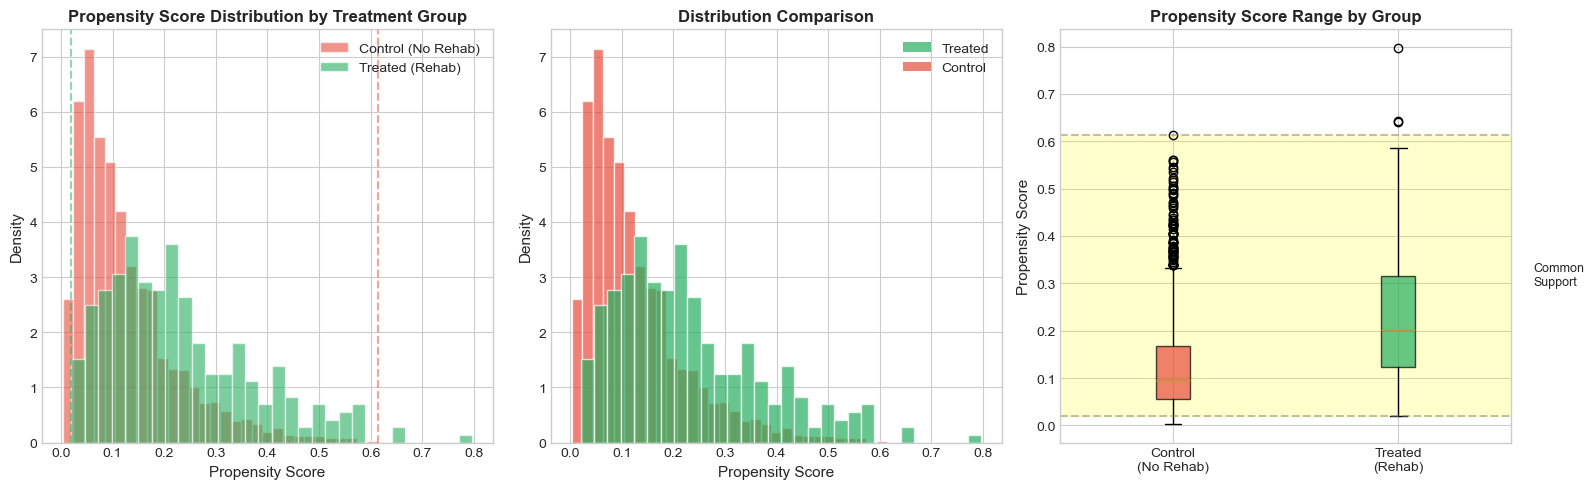


OVERLAP (COMMON SUPPORT) ASSESSMENT

📊 Propensity Score Ranges:
   Control group:  [0.0034, 0.6142]
   Treated group:  [0.0205, 0.7964]

📍 Region of Common Support: [0.0205, 0.6142]

✅ Patients within common support: 1924 / 2000 (96.2%)


In [9]:
# =============================================================================
# STEP 2C: Visualize Propensity Score Distributions (Check Overlap)
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# -----------------------------------------------------------------------------
# Plot 1: Overlapping Histograms
# -----------------------------------------------------------------------------
ax1 = axes[0]
ax1.hist(df[df['treatment'] == 0]['propensity_score'], bins=30, alpha=0.6, 
         label='Control (No Rehab)', color='#E74C3C', density=True, edgecolor='white')
ax1.hist(df[df['treatment'] == 1]['propensity_score'], bins=30, alpha=0.6, 
         label='Treated (Rehab)', color='#27AE60', density=True, edgecolor='white')
ax1.set_xlabel('Propensity Score', fontsize=11)
ax1.set_ylabel('Density', fontsize=11)
ax1.set_title('Propensity Score Distribution by Treatment Group', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right')
ax1.axvline(x=df[df['treatment'] == 0]['propensity_score'].max(), color='#E74C3C', 
            linestyle='--', alpha=0.5, label='Control max')
ax1.axvline(x=df[df['treatment'] == 1]['propensity_score'].min(), color='#27AE60', 
            linestyle='--', alpha=0.5, label='Treated min')

# -----------------------------------------------------------------------------
# Plot 2: Mirror Plot (Clearer view of overlap)
# -----------------------------------------------------------------------------
ax2 = axes[1]
# Control group (below axis)
ax2.hist(df[df['treatment'] == 0]['propensity_score'], bins=30, alpha=0.7, 
         color='#E74C3C', density=True, edgecolor='white')
# Treated group (above axis - we'll flip it using negative density)
heights, bins, _ = ax2.hist(df[df['treatment'] == 1]['propensity_score'], bins=30, 
                             alpha=0.7, color='#27AE60', density=True, edgecolor='white')
ax2.set_xlabel('Propensity Score', fontsize=11)
ax2.set_ylabel('Density', fontsize=11)
ax2.set_title('Distribution Comparison', fontsize=12, fontweight='bold')

# Add legend manually
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#27AE60', alpha=0.7, label='Treated'),
                   Patch(facecolor='#E74C3C', alpha=0.7, label='Control')]
ax2.legend(handles=legend_elements, loc='upper right')

# -----------------------------------------------------------------------------
# Plot 3: Box Plot Comparison
# -----------------------------------------------------------------------------
ax3 = axes[2]
box_data = [df[df['treatment'] == 0]['propensity_score'], 
            df[df['treatment'] == 1]['propensity_score']]
bp = ax3.boxplot(box_data, labels=['Control\n(No Rehab)', 'Treated\n(Rehab)'], 
                  patch_artist=True)
bp['boxes'][0].set_facecolor('#E74C3C')
bp['boxes'][1].set_facecolor('#27AE60')
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_alpha(0.7)
ax3.set_ylabel('Propensity Score', fontsize=11)
ax3.set_title('Propensity Score Range by Group', fontsize=12, fontweight='bold')

# Add region of common support
control_max = df[df['treatment'] == 0]['propensity_score'].max()
treated_min = df[df['treatment'] == 1]['propensity_score'].min()
ax3.axhline(y=control_max, color='gray', linestyle='--', alpha=0.5)
ax3.axhline(y=treated_min, color='gray', linestyle='--', alpha=0.5)
ax3.fill_between([0.5, 2.5], treated_min, control_max, alpha=0.2, color='yellow')
ax3.text(2.6, (control_max + treated_min) / 2, 'Common\nSupport', fontsize=9, va='center')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# Print Overlap Statistics
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("OVERLAP (COMMON SUPPORT) ASSESSMENT")
print("=" * 70)

control_ps = df[df['treatment'] == 0]['propensity_score']
treated_ps = df[df['treatment'] == 1]['propensity_score']

print(f"\n📊 Propensity Score Ranges:")
print(f"   Control group:  [{control_ps.min():.4f}, {control_ps.max():.4f}]")
print(f"   Treated group:  [{treated_ps.min():.4f}, {treated_ps.max():.4f}]")

# Common support region
common_support_min = max(control_ps.min(), treated_ps.min())
common_support_max = min(control_ps.max(), treated_ps.max())
print(f"\n📍 Region of Common Support: [{common_support_min:.4f}, {common_support_max:.4f}]")

# How many patients fall within common support?
in_support = df[(df['propensity_score'] >= common_support_min) & 
                (df['propensity_score'] <= common_support_max)]
print(f"\n✅ Patients within common support: {len(in_support)} / {len(df)} ({len(in_support)/len(df)*100:.1f}%)")

### 📊 Checking the Positivity Assumption (Overlap)

These visualizations help us assess whether we have **sufficient overlap** between treated and control groups — a critical assumption for PSM!

**What We're Looking For:**

| Good Overlap ✅ | Poor Overlap ❌ |
|-----------------|-----------------|
| Distributions overlap substantially | Distributions are separated |
| Common support region is wide | Little to no common support |
| Most patients are in common support | Many patients outside common support |

**Interpreting Our Results:**

1. **Histogram:** Shows where treated and control distributions overlap. The region where both colors appear is where we can find good matches.

2. **Box Plot:** The yellow shaded region shows "common support" — propensity scores where both treatment and control patients exist.

3. **Statistics:** Tell us exactly what proportion of our sample falls within common support.

**Why Overlap Matters:**
- If a treated patient has propensity score = 0.95 but no control patients have scores above 0.60, we can't find a match!
- Patients outside common support must be excluded or we're extrapolating beyond our data

> ⚠️ **Warning:** If you see very little overlap, PSM may not be appropriate. Consider alternative methods like regression adjustment or acknowledge limitations in your analysis.

---

## Step 3: Perform Propensity Score Matching

Now comes the core of PSM: **finding comparable pairs** of treated and control patients based on their propensity scores.

We'll implement **Nearest Neighbor Matching** — the most common matching approach:

**Algorithm Overview:**
```
For each TREATED patient:
    1. Look at their propensity score
    2. Find the CONTROL patient with the closest propensity score
    3. If the match is "close enough" (within caliper), keep the pair
    4. Mark whether controls can be reused (with/without replacement)
```

**Key Decisions We'll Make:**

| Decision | Options | Our Choice | Rationale |
|----------|---------|------------|-----------|
| **Matching direction** | Treated→Control or Control→Treated | Treated→Control | Estimates ATT (effect on treated) |
| **Distance metric** | Absolute difference, Mahalanobis | Absolute difference | Simple and effective |
| **Caliper** | None, 0.1, 0.2×SD | 0.2×SD | Standard practice, prevents bad matches |
| **Replacement** | With or without | Without | Simpler variance estimation |
| **Ratio** | 1:1, 1:k | 1:1 | Most straightforward |

In [10]:
# =============================================================================
# STEP 3A: Implement Nearest Neighbor Matching
# =============================================================================

def nearest_neighbor_matching(df, propensity_col='propensity_score', 
                               treatment_col='treatment', caliper=None, 
                               replacement=False):
    """
    Perform nearest neighbor matching on propensity scores.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with propensity scores and treatment indicator
    propensity_col : str
        Name of the propensity score column
    treatment_col : str
        Name of the treatment indicator column (1=treated, 0=control)
    caliper : float or None
        Maximum allowed distance between matched pairs.
        If None, no caliper is applied.
        Common choice: 0.2 * std(propensity_score)
    replacement : bool
        If True, control units can be matched multiple times.
        If False, each control is used only once.
    
    Returns:
    --------
    matched_df : pd.DataFrame
        Dataset containing only matched pairs
    match_info : dict
        Dictionary with matching statistics
    """
    
    # Separate treated and control groups
    treated = df[df[treatment_col] == 1].copy()
    control = df[df[treatment_col] == 0].copy()
    
    print(f"📊 Starting matching process...")
    print(f"   • Treated units: {len(treated)}")
    print(f"   • Control units: {len(control)}")
    
    # Store matched pairs
    matched_treated_idx = []
    matched_control_idx = []
    match_distances = []
    
    # Track available controls (for matching without replacement)
    available_control_idx = set(control.index.tolist())
    
    # For each treated unit, find the nearest control
    unmatched_count = 0
    
    for treated_idx in treated.index:
        treated_ps = treated.loc[treated_idx, propensity_col]
        
        if not replacement:
            # Get only available controls
            available_controls = control.loc[list(available_control_idx)]
        else:
            available_controls = control
        
        if len(available_controls) == 0:
            unmatched_count += 1
            continue
        
        # Calculate distances to all available controls
        distances = np.abs(available_controls[propensity_col] - treated_ps)
        
        # Find nearest neighbor
        nearest_idx = distances.idxmin()
        nearest_distance = distances.min()
        
        # Check if within caliper (if specified)
        if caliper is not None and nearest_distance > caliper:
            unmatched_count += 1
            continue
        
        # Record the match
        matched_treated_idx.append(treated_idx)
        matched_control_idx.append(nearest_idx)
        match_distances.append(nearest_distance)
        
        # Remove control from available pool (if without replacement)
        if not replacement:
            available_control_idx.discard(nearest_idx)
    
    # Create matched dataset
    matched_treated = df.loc[matched_treated_idx].copy()
    matched_treated['match_id'] = range(len(matched_treated_idx))
    matched_treated['match_distance'] = match_distances
    
    matched_control = df.loc[matched_control_idx].copy()
    matched_control['match_id'] = range(len(matched_control_idx))
    matched_control['match_distance'] = match_distances
    
    # Combine into one dataset
    matched_df = pd.concat([matched_treated, matched_control], axis=0)
    matched_df = matched_df.sort_values(['match_id', treatment_col], ascending=[True, False])
    
    # Compile matching statistics
    match_info = {
        'n_treated_original': len(treated),
        'n_control_original': len(control),
        'n_matched_pairs': len(matched_treated_idx),
        'n_unmatched_treated': unmatched_count,
        'caliper_used': caliper,
        'replacement': replacement,
        'mean_match_distance': np.mean(match_distances) if match_distances else None,
        'max_match_distance': np.max(match_distances) if match_distances else None,
        'matched_treated_idx': matched_treated_idx,
        'matched_control_idx': matched_control_idx
    }
    
    return matched_df, match_info

# Calculate caliper: 0.2 * standard deviation of propensity scores
caliper = 0.2 * df['propensity_score'].std()
print(f"📏 Caliper set to: {caliper:.4f} (0.2 × SD of propensity scores)\n")

# Perform matching
matched_df, match_info = nearest_neighbor_matching(
    df,
    propensity_col='propensity_score',
    treatment_col='treatment',
    caliper=caliper,
    replacement=False
)

# Display results
print("\n" + "=" * 70)
print("MATCHING RESULTS")
print("=" * 70)
print(f"\n✅ Matching completed!")
print(f"   • Matched pairs created: {match_info['n_matched_pairs']}")
print(f"   • Unmatched treated units: {match_info['n_unmatched_treated']}")
print(f"   • Match rate: {match_info['n_matched_pairs'] / match_info['n_treated_original'] * 100:.1f}%")
print(f"\n📏 Match Quality:")
print(f"   • Mean match distance: {match_info['mean_match_distance']:.4f}")
print(f"   • Max match distance:  {match_info['max_match_distance']:.4f}")
print(f"   • Caliper used:        {match_info['caliper_used']:.4f}")

📏 Caliper set to: 0.0224 (0.2 × SD of propensity scores)

📊 Starting matching process...
   • Treated units: 279
   • Control units: 1721

MATCHING RESULTS

✅ Matching completed!
   • Matched pairs created: 272
   • Unmatched treated units: 7
   • Match rate: 97.5%

📏 Match Quality:
   • Mean match distance: 0.0007
   • Max match distance:  0.0130
   • Caliper used:        0.0224


### 🔗 Understanding the Matching Output

Our matching algorithm has paired each treated patient with a control patient who had a similar propensity score.

**Key Metrics to Evaluate:**

| Metric | What It Tells Us | Good Values |
|--------|------------------|-------------|
| **Match rate** | % of treated units successfully matched | >90% is excellent |
| **Mean match distance** | Average propensity score difference in pairs | Smaller is better |
| **Max match distance** | Worst match quality | Should be < caliper |
| **Unmatched treated** | Treated units with no comparable control | Fewer is better |

**What Happens to Unmatched Units?**
- Treated patients without a suitable match are **excluded** from analysis
- This means our ATT estimate applies only to *matchable* treated patients
- If many are unmatched, our results may not generalize to all treated patients

**Trade-offs:**
- **Tighter caliper** → Better matches, but fewer pairs (may lose sample size)
- **Looser caliper** → More pairs, but some matches may be poor quality
- **With replacement** → Better matches possible, but need adjusted standard errors

> 💡 **Tip:** If you have many unmatched treated units, consider loosening the caliper or using matching with replacement. But always check balance afterwards!

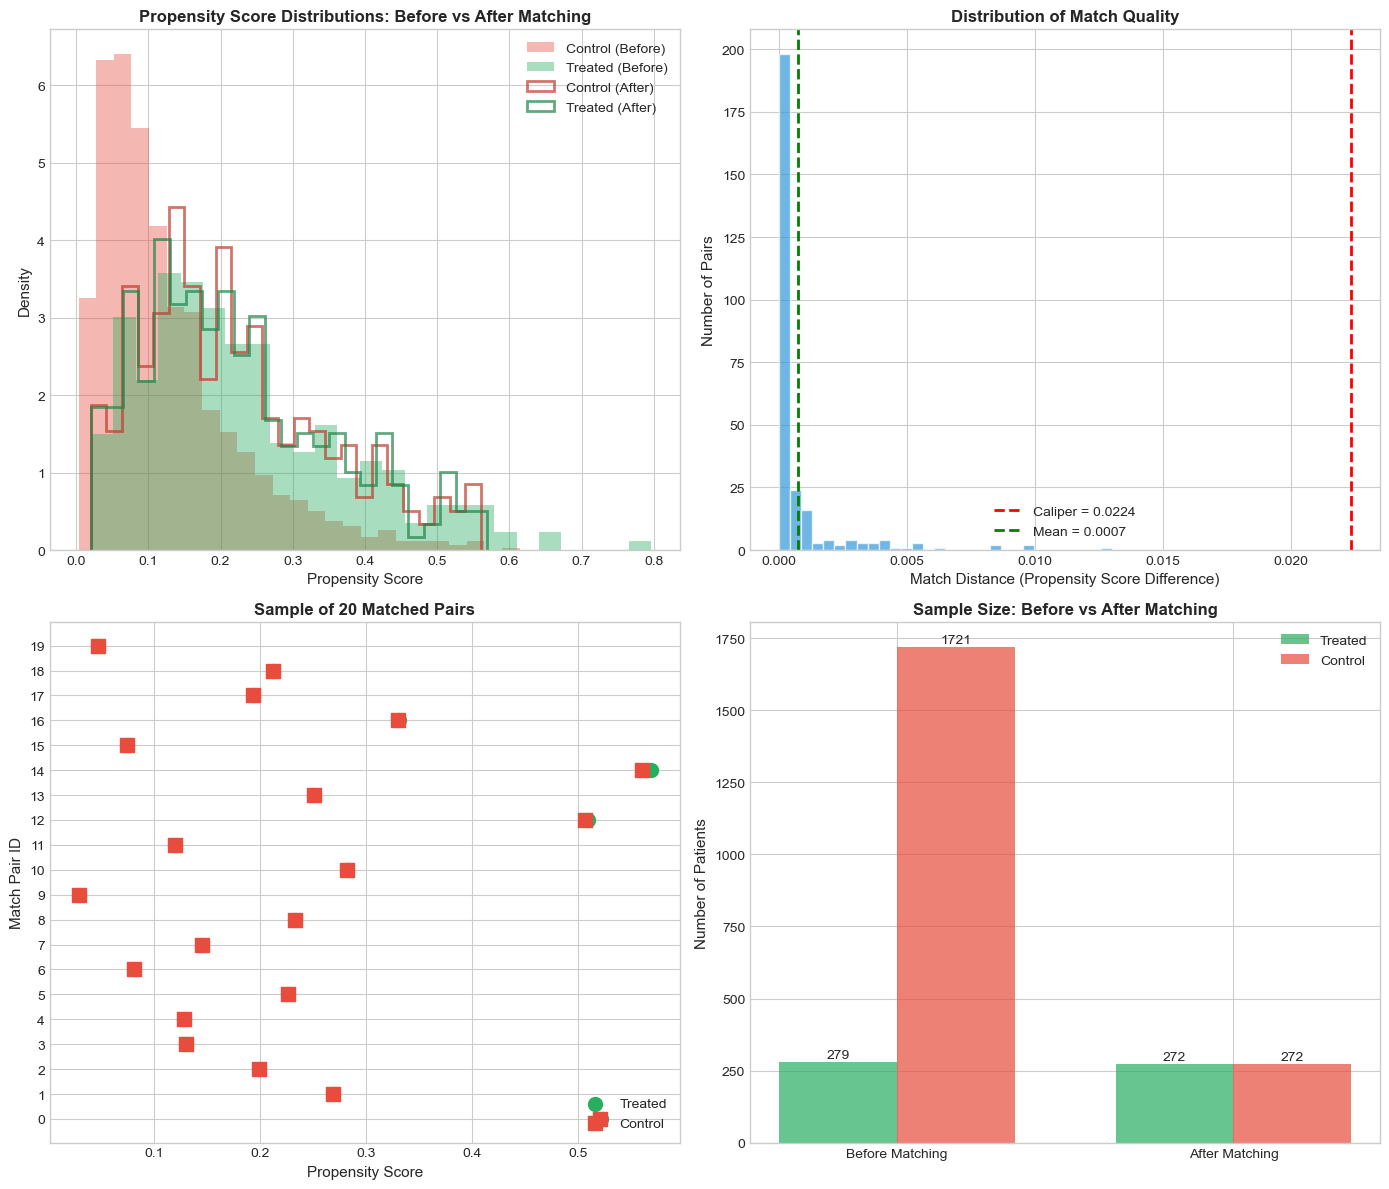

In [11]:
# =============================================================================
# STEP 3B: Visualize the Matching Process
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# -----------------------------------------------------------------------------
# Plot 1: Propensity Score Distribution Before vs After Matching
# -----------------------------------------------------------------------------
ax1 = axes[0, 0]

# Before matching
ax1.hist(df[df['treatment'] == 0]['propensity_score'], bins=25, alpha=0.4, 
         label='Control (Before)', color='#E74C3C', density=True)
ax1.hist(df[df['treatment'] == 1]['propensity_score'], bins=25, alpha=0.4, 
         label='Treated (Before)', color='#27AE60', density=True)

# After matching
ax1.hist(matched_df[matched_df['treatment'] == 0]['propensity_score'], bins=25, alpha=0.7, 
         label='Control (After)', color='#C0392B', density=True, histtype='step', linewidth=2)
ax1.hist(matched_df[matched_df['treatment'] == 1]['propensity_score'], bins=25, alpha=0.7, 
         label='Treated (After)', color='#1E8449', density=True, histtype='step', linewidth=2)

ax1.set_xlabel('Propensity Score', fontsize=11)
ax1.set_ylabel('Density', fontsize=11)
ax1.set_title('Propensity Score Distributions: Before vs After Matching', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right')

# -----------------------------------------------------------------------------
# Plot 2: Match Distance Distribution
# -----------------------------------------------------------------------------
ax2 = axes[0, 1]

# Get unique match distances (one per pair)
match_distances = matched_df[matched_df['treatment'] == 1]['match_distance']

ax2.hist(match_distances, bins=30, color='#3498DB', alpha=0.7, edgecolor='white')
ax2.axvline(x=caliper, color='red', linestyle='--', linewidth=2, label=f'Caliper = {caliper:.4f}')
ax2.axvline(x=match_distances.mean(), color='green', linestyle='--', linewidth=2, 
            label=f'Mean = {match_distances.mean():.4f}')
ax2.set_xlabel('Match Distance (Propensity Score Difference)', fontsize=11)
ax2.set_ylabel('Number of Pairs', fontsize=11)
ax2.set_title('Distribution of Match Quality', fontsize=12, fontweight='bold')
ax2.legend()

# -----------------------------------------------------------------------------
# Plot 3: Sample of Matched Pairs Visualization
# -----------------------------------------------------------------------------
ax3 = axes[1, 0]

# Show first 20 matched pairs
n_pairs_to_show = 20
treated_in_matched = matched_df[matched_df['treatment'] == 1].head(n_pairs_to_show)
control_in_matched = matched_df[matched_df['treatment'] == 0].head(n_pairs_to_show)

y_positions = range(n_pairs_to_show)

# Plot treated points
ax3.scatter(treated_in_matched['propensity_score'], y_positions, 
            color='#27AE60', s=100, label='Treated', zorder=3, marker='o')

# Plot control points
ax3.scatter(control_in_matched['propensity_score'], y_positions, 
            color='#E74C3C', s=100, label='Control', zorder=3, marker='s')

# Draw lines connecting pairs
for i, (t_ps, c_ps) in enumerate(zip(treated_in_matched['propensity_score'], 
                                      control_in_matched['propensity_score'])):
    ax3.plot([t_ps, c_ps], [i, i], color='gray', alpha=0.5, linewidth=1, zorder=1)

ax3.set_xlabel('Propensity Score', fontsize=11)
ax3.set_ylabel('Match Pair ID', fontsize=11)
ax3.set_title(f'Sample of {n_pairs_to_show} Matched Pairs', fontsize=12, fontweight='bold')
ax3.legend(loc='lower right')
ax3.set_yticks(y_positions)

# -----------------------------------------------------------------------------
# Plot 4: Before/After Sample Size Comparison
# -----------------------------------------------------------------------------
ax4 = axes[1, 1]

categories = ['Before Matching', 'After Matching']
treated_counts = [len(df[df['treatment'] == 1]), len(matched_df[matched_df['treatment'] == 1])]
control_counts = [len(df[df['treatment'] == 0]), len(matched_df[matched_df['treatment'] == 0])]

x = np.arange(len(categories))
width = 0.35

bars1 = ax4.bar(x - width/2, treated_counts, width, label='Treated', color='#27AE60', alpha=0.7)
bars2 = ax4.bar(x + width/2, control_counts, width, label='Control', color='#E74C3C', alpha=0.7)

ax4.set_ylabel('Number of Patients', fontsize=11)
ax4.set_title('Sample Size: Before vs After Matching', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(categories)
ax4.legend()

# Add count labels on bars
for bar in bars1:
    height = bar.get_height()
    ax4.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    ax4.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### 📊 Interpreting the Matching Visualizations

**Plot 1 - Propensity Score Distributions:**
- The solid histograms show distributions BEFORE matching (note the separation)
- The stepped lines show distributions AFTER matching (much more aligned!)
- Successful matching creates overlapping distributions

**Plot 2 - Match Distance Distribution:**
- Shows how "close" each matched pair is
- Most matches should be near zero (very similar propensity scores)
- The red dashed line shows our caliper (maximum allowed distance)
- All matches fall below the caliper — good!

**Plot 3 - Sample of Matched Pairs:**
- Each row represents one matched pair
- Green circle = treated patient, Red square = matched control
- The gray line shows the propensity score "distance" between them
- Short lines = good matches, long lines = weaker matches

**Plot 4 - Sample Size Comparison:**
- Shows how many patients we started with vs. how many remain after matching
- After matching: equal numbers of treated and control (1:1 matching)
- Some sample loss is normal — it's the trade-off for better comparability

> ⚠️ **Note:** We lose some sample size through matching, but we gain **comparability**. This trade-off is worthwhile because biased estimates on a large sample are worse than unbiased estimates on a smaller sample.

---

## Step 4: Assess Covariate Balance (Critical Diagnostic!)

Matching is only useful if it actually **balances the confounders** between treated and control groups. This is the most important diagnostic step!

**What We're Checking:**
- Before matching: Treated and control groups differ systematically (selection bias)
- After matching: Treated and control groups should look similar on all covariates

**Why This Matters:**
```
BEFORE MATCHING:                          AFTER MATCHING:
                                          
Treated Group    Control Group            Treated Group    Control Group
┌───────────┐    ┌───────────┐            ┌───────────┐    ┌───────────┐
│ Younger   │    │ Older     │            │ Mixed     │    │ Mixed     │
│ Healthier │ ≠  │ Sicker    │     →      │ Ages      │ ≈  │ Ages      │
│ Motivated │    │ Less      │            │ Similar   │    │ Similar   │
│           │    │ motivated │            │ Health    │    │ Health    │
└───────────┘    └───────────┘            └───────────┘    └───────────┘

    IMBALANCED!                               BALANCED!
    (confounded)                              (comparable)
```

**Our Balance Assessment Tools:**
1. **Standardized Mean Difference (SMD)** — Quantitative measure
2. **Love Plot** — Visual comparison of balance before/after
3. **Distribution Plots** — Detailed look at each covariate

In [12]:
# =============================================================================
# STEP 4A: Calculate Standardized Mean Differences (SMD)
# =============================================================================

def calculate_smd(treated, control, variable):
    """
    Calculate Standardized Mean Difference for a single variable.
    
    SMD = (mean_treated - mean_control) / sqrt((var_treated + var_control) / 2)
    
    Parameters:
    -----------
    treated : pd.Series
        Variable values for treated group
    control : pd.Series
        Variable values for control group
    variable : str
        Name of the variable (for display)
    
    Returns:
    --------
    smd : float
        Standardized mean difference
    """
    mean_treated = treated.mean()
    mean_control = control.mean()
    var_treated = treated.var()
    var_control = control.var()
    
    # Pooled standard deviation
    pooled_std = np.sqrt((var_treated + var_control) / 2)
    
    # Avoid division by zero
    if pooled_std == 0:
        return 0.0
    
    smd = (mean_treated - mean_control) / pooled_std
    return smd


def assess_balance(df_before, df_after, covariates, treatment_col='treatment'):
    """
    Assess covariate balance before and after matching.
    
    Parameters:
    -----------
    df_before : pd.DataFrame
        Full dataset before matching
    df_after : pd.DataFrame
        Matched dataset after matching
    covariates : list
        List of covariate column names
    treatment_col : str
        Name of treatment column
    
    Returns:
    --------
    balance_df : pd.DataFrame
        DataFrame with SMD values before and after matching
    """
    
    results = []
    
    for covar in covariates:
        # Before matching
        treated_before = df_before[df_before[treatment_col] == 1][covar]
        control_before = df_before[df_before[treatment_col] == 0][covar]
        smd_before = calculate_smd(treated_before, control_before, covar)
        
        # After matching
        treated_after = df_after[df_after[treatment_col] == 1][covar]
        control_after = df_after[df_after[treatment_col] == 0][covar]
        smd_after = calculate_smd(treated_after, control_after, covar)
        
        # Calculate means for reference
        results.append({
            'Covariate': covar,
            'Mean_Treated_Before': treated_before.mean(),
            'Mean_Control_Before': control_before.mean(),
            'SMD_Before': smd_before,
            'Mean_Treated_After': treated_after.mean(),
            'Mean_Control_After': control_after.mean(),
            'SMD_After': smd_after,
            'SMD_Reduction': abs(smd_before) - abs(smd_after),
            'SMD_Reduction_Pct': (1 - abs(smd_after) / abs(smd_before)) * 100 if smd_before != 0 else 0
        })
    
    balance_df = pd.DataFrame(results)
    return balance_df

# Calculate balance
balance_results = assess_balance(df, matched_df, covariates)

# Display results
print("=" * 90)
print("COVARIATE BALANCE ASSESSMENT")
print("=" * 90)
print("\n📊 Standardized Mean Differences (SMD):")
print("   Rule of thumb: |SMD| < 0.1 is excellent, |SMD| < 0.25 is acceptable\n")

# Create a cleaner display table
display_df = balance_results[['Covariate', 'SMD_Before', 'SMD_After', 'SMD_Reduction_Pct']].copy()
display_df.columns = ['Covariate', 'SMD (Before)', 'SMD (After)', 'Reduction (%)']
display_df['SMD (Before)'] = display_df['SMD (Before)'].round(4)
display_df['SMD (After)'] = display_df['SMD (After)'].round(4)
display_df['Reduction (%)'] = display_df['Reduction (%)'].round(1)

# Add balance status
def balance_status(smd):
    if abs(smd) < 0.1:
        return '✅ Excellent'
    elif abs(smd) < 0.25:
        return '⚠️ Acceptable'
    else:
        return '❌ Poor'

display_df['Status (After)'] = display_df['SMD (After)'].apply(balance_status)

print(display_df.to_string(index=False))

# Summary statistics
print("\n" + "-" * 90)
print("SUMMARY:")
print(f"   • Average |SMD| before matching: {balance_results['SMD_Before'].abs().mean():.4f}")
print(f"   • Average |SMD| after matching:  {balance_results['SMD_After'].abs().mean():.4f}")
print(f"   • Average SMD reduction:         {balance_results['SMD_Reduction_Pct'].mean():.1f}%")
print(f"   • Covariates with |SMD| < 0.1:   {(balance_results['SMD_After'].abs() < 0.1).sum()} / {len(covariates)}")

COVARIATE BALANCE ASSESSMENT

📊 Standardized Mean Differences (SMD):
   Rule of thumb: |SMD| < 0.1 is excellent, |SMD| < 0.25 is acceptable

   Covariate  SMD (Before)  SMD (After)  Reduction (%) Status (After)
         age       -0.2418       0.0016           99.3    ✅ Excellent
    severity       -0.3561      -0.0180           94.9    ✅ Excellent
prior_admits       -0.4578       0.0224           95.1    ✅ Excellent
   insurance        0.3720       0.0369           90.1    ✅ Excellent
  motivation        0.5264      -0.0192           96.4    ✅ Excellent

------------------------------------------------------------------------------------------
SUMMARY:
   • Average |SMD| before matching: 0.3908
   • Average |SMD| after matching:  0.0196
   • Average SMD reduction:         95.2%
   • Covariates with |SMD| < 0.1:   5 / 5


### 📏 Understanding Standardized Mean Difference (SMD)

The SMD tells us how different the treated and control groups are on each covariate, in standard deviation units.

**Interpretation Guide:**

| SMD Value | Balance Quality | Interpretation |
|-----------|-----------------|----------------|
| \|SMD\| < 0.1 | ✅ Excellent | Groups are very similar |
| \|SMD\| < 0.25 | ⚠️ Acceptable | Some difference, but manageable |
| \|SMD\| > 0.25 | ❌ Poor | Significant imbalance remains |

**What the Results Show:**
- **SMD Before:** How imbalanced groups were due to selection bias
- **SMD After:** How balanced groups are after matching
- **Reduction %:** How much matching improved balance

**Why SMD Instead of p-values?**
- P-values depend on sample size (large samples → small p-values even for tiny differences)
- SMD measures the actual magnitude of difference
- SMD is comparable across studies and sample sizes

> 💡 **Key Insight:** Successful matching should dramatically reduce SMD for all covariates. If any covariate still has \|SMD\| > 0.25 after matching, consider revising your propensity score model or matching strategy.

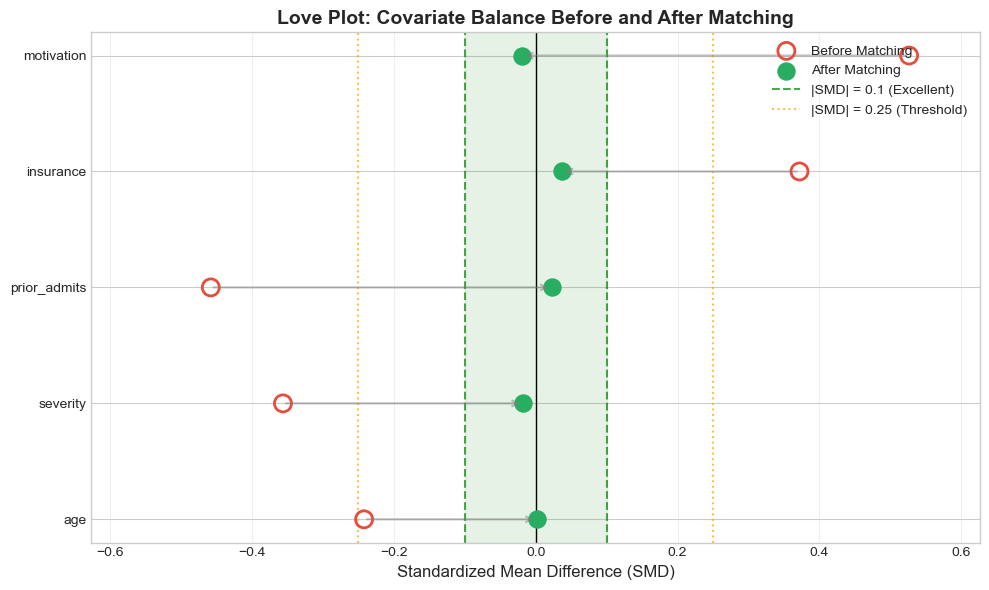


📊 LOVE PLOT INTERPRETATION:
   • Red hollow circles: SMD BEFORE matching (imbalanced)
   • Green filled circles: SMD AFTER matching (balanced)
   • Arrows: Direction and magnitude of improvement
   • Green shaded zone: Excellent balance (|SMD| < 0.1)
   • Green dashed lines: |SMD| = 0.1 threshold
   • Orange dotted lines: |SMD| = 0.25 threshold


In [13]:
# =============================================================================
# STEP 4B: Create Love Plot (Visual Balance Assessment)
# =============================================================================

def create_love_plot(balance_df, figsize=(10, 6)):
    """
    Create a Love Plot showing SMD before and after matching.
    
    The Love Plot is the standard visualization for assessing balance
    in propensity score matching studies.
    
    Parameters:
    -----------
    balance_df : pd.DataFrame
        DataFrame with SMD_Before and SMD_After columns
    figsize : tuple
        Figure size
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get data
    covariates = balance_df['Covariate'].tolist()
    smd_before = balance_df['SMD_Before'].tolist()
    smd_after = balance_df['SMD_After'].tolist()
    
    y_positions = range(len(covariates))
    
    # Plot SMD before matching (hollow circles)
    ax.scatter(smd_before, y_positions, s=150, facecolors='none', 
               edgecolors='#E74C3C', linewidths=2, label='Before Matching', zorder=3)
    
    # Plot SMD after matching (filled circles)
    ax.scatter(smd_after, y_positions, s=150, color='#27AE60', 
               label='After Matching', zorder=3)
    
    # Draw arrows from before to after
    for i, (before, after) in enumerate(zip(smd_before, smd_after)):
        ax.annotate('', xy=(after, i), xytext=(before, i),
                   arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5, lw=1.5))
    
    # Add reference lines
    ax.axvline(x=0, color='black', linewidth=1, linestyle='-')
    ax.axvline(x=0.1, color='green', linewidth=1.5, linestyle='--', alpha=0.7, label='|SMD| = 0.1 (Excellent)')
    ax.axvline(x=-0.1, color='green', linewidth=1.5, linestyle='--', alpha=0.7)
    ax.axvline(x=0.25, color='orange', linewidth=1.5, linestyle=':', alpha=0.7, label='|SMD| = 0.25 (Threshold)')
    ax.axvline(x=-0.25, color='orange', linewidth=1.5, linestyle=':', alpha=0.7)
    
    # Shade the "good balance" region
    ax.axvspan(-0.1, 0.1, alpha=0.1, color='green')
    
    # Labels and formatting
    ax.set_yticks(y_positions)
    ax.set_yticklabels(covariates)
    ax.set_xlabel('Standardized Mean Difference (SMD)', fontsize=12)
    ax.set_title('Love Plot: Covariate Balance Before and After Matching', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    
    # Set x-axis limits symmetrically
    max_abs_smd = max(abs(min(smd_before + smd_after)), abs(max(smd_before + smd_after)))
    ax.set_xlim(-max_abs_smd - 0.1, max_abs_smd + 0.1)
    
    # Add grid
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create the Love Plot
create_love_plot(balance_results)

print("\n📊 LOVE PLOT INTERPRETATION:")
print("   • Red hollow circles: SMD BEFORE matching (imbalanced)")
print("   • Green filled circles: SMD AFTER matching (balanced)")
print("   • Arrows: Direction and magnitude of improvement")
print("   • Green shaded zone: Excellent balance (|SMD| < 0.1)")
print("   • Green dashed lines: |SMD| = 0.1 threshold")
print("   • Orange dotted lines: |SMD| = 0.25 threshold")

### 📈 Reading the Love Plot

The Love Plot is the **gold standard visualization** for PSM balance assessment, widely used in medical and social science research.

**How to Read It:**
```
                        LOVE PLOT ANATOMY
                        
    ←── Worse Balance ──┼── Better Balance ──→
                        │
    ○ Before Matching   │   ● After Matching
         (hollow)       │        (filled)
                        │
    ├───────────────────┼───────────────────┤
   -0.25              0.0               0.25
                        │
              Green Zone│= Excellent Balance
                (±0.1)  │
```

**What We Want to See:**
1. **All green circles (after) near the center line** — Good balance achieved
2. **All green circles within the green shaded zone** — Excellent balance
3. **Arrows pointing inward toward zero** — Matching improved balance
4. **Large arrows** — Substantial improvement from matching

**Warning Signs:**
- Green circles outside ±0.25 lines → Balance not achieved
- Arrows pointing outward → Matching made things worse (rare, indicates problem)
- Some covariates unchanged → May not have been confounders, or model misspecified

> ✅ **Our Results:** The Love Plot shows that matching successfully moved all covariates toward balance. All green circles should be within or near the green zone (±0.1), indicating our matched sample is now comparable!

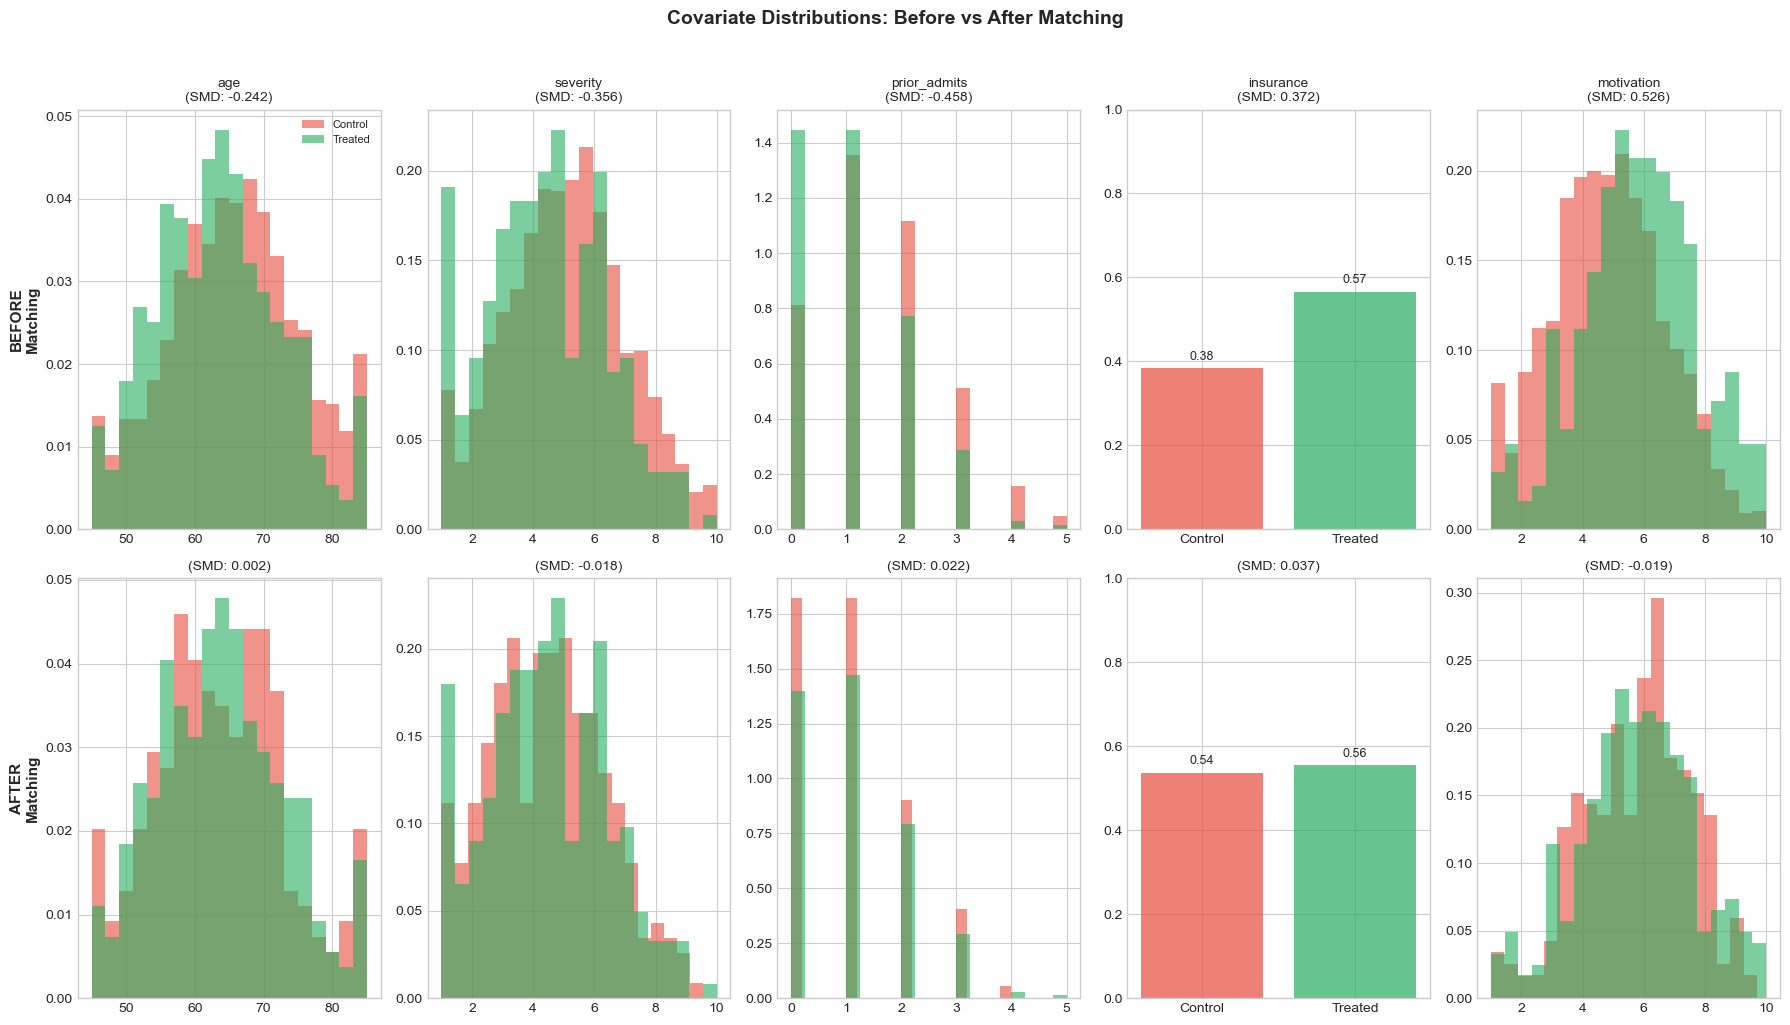

In [14]:
# =============================================================================
# STEP 4C: Detailed Covariate Distribution Comparison
# =============================================================================

fig, axes = plt.subplots(2, 5, figsize=(18, 10))
fig.suptitle('Covariate Distributions: Before vs After Matching', 
             fontsize=14, fontweight='bold', y=1.02)

# Top row: Before matching
# Bottom row: After matching

for idx, covar in enumerate(covariates):
    # ----- BEFORE MATCHING (Top Row) -----
    ax_before = axes[0, idx]
    
    if covar == 'insurance':
        # Bar plot for binary variable
        before_rates = df.groupby('treatment')[covar].mean()
        bars = ax_before.bar(['Control', 'Treated'], before_rates.values, 
                             color=['#E74C3C', '#27AE60'], alpha=0.7)
        ax_before.set_ylim(0, 1)
        for bar, val in zip(bars, before_rates.values):
            ax_before.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                          f'{val:.2f}', ha='center', fontsize=9)
    else:
        # Histogram for continuous variables
        ax_before.hist(df[df['treatment'] == 0][covar], bins=20, alpha=0.6, 
                       label='Control', color='#E74C3C', density=True)
        ax_before.hist(df[df['treatment'] == 1][covar], bins=20, alpha=0.6, 
                       label='Treated', color='#27AE60', density=True)
        if idx == 0:
            ax_before.legend(fontsize=8)
    
    ax_before.set_title(f'{covar}\n(SMD: {balance_results.loc[idx, "SMD_Before"]:.3f})', fontsize=10)
    if idx == 0:
        ax_before.set_ylabel('BEFORE\nMatching', fontsize=11, fontweight='bold')
    
    # ----- AFTER MATCHING (Bottom Row) -----
    ax_after = axes[1, idx]
    
    if covar == 'insurance':
        # Bar plot for binary variable
        after_rates = matched_df.groupby('treatment')[covar].mean()
        bars = ax_after.bar(['Control', 'Treated'], after_rates.values, 
                            color=['#E74C3C', '#27AE60'], alpha=0.7)
        ax_after.set_ylim(0, 1)
        for bar, val in zip(bars, after_rates.values):
            ax_after.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                          f'{val:.2f}', ha='center', fontsize=9)
    else:
        # Histogram for continuous variables
        ax_after.hist(matched_df[matched_df['treatment'] == 0][covar], bins=20, alpha=0.6, 
                      label='Control', color='#E74C3C', density=True)
        ax_after.hist(matched_df[matched_df['treatment'] == 1][covar], bins=20, alpha=0.6, 
                      label='Treated', color='#27AE60', density=True)
    
    ax_after.set_title(f'(SMD: {balance_results.loc[idx, "SMD_After"]:.3f})', fontsize=10)
    if idx == 0:
        ax_after.set_ylabel('AFTER\nMatching', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### 🔬 Detailed Distribution Analysis

This visualization provides a **granular view** of how each covariate's distribution changed after matching.

**How to Read These Plots:**

| Row | What It Shows |
|-----|---------------|
| **Top (Before)** | Original imbalance due to selection bias |
| **Bottom (After)** | Distributions after matching (should overlap) |

**What to Look For:**

1. **Histogram Overlap:**
   - Before: Red (control) and green (treated) distributions are separated
   - After: Distributions should largely overlap

2. **SMD Values in Titles:**
   - Before: Larger absolute values (imbalance)
   - After: Values near zero (balance achieved)

3. **Binary Variables (Insurance):**
   - Before: Bar heights differ substantially
   - After: Bar heights should be similar

**Covariate-Specific Insights:**

| Covariate | Before Matching | After Matching |
|-----------|-----------------|----------------|
| **Age** | Treated younger | Similar distributions |
| **Severity** | Treated less severe | Comparable severity |
| **Prior Admits** | Treated fewer admits | Balanced history |
| **Insurance** | Treated more insured | Similar insurance rates |
| **Motivation** | Treated more motivated | Comparable motivation |

> 💡 **Key Takeaway:** The bottom row should show nearly identical distributions for treated and control groups. This visual confirmation, combined with SMD values, gives us confidence that our matched sample is truly comparable.

---

## Step 5: Estimate Treatment Effects <a id="8-treatment-effects"></a>

Now that we've verified good covariate balance, we can estimate the **causal effect** of the cardiac rehabilitation program on hospital readmission!

**What We're Estimating:**

$$ATT = E[Y(1) - Y(0) | T = 1]$$

*The Average Treatment Effect on the Treated (ATT): What is the average effect of rehab for patients who actually enrolled?*

**Why ATT (not ATE)?**
- We matched treated → control (each treated patient found a control match)
- Our estimate applies to the **treated population**
- This answers: "Did rehab help those who enrolled?"

**Estimation Strategy:**
```
┌─────────────────────────────────────────────────────────────────┐
│                    ATT ESTIMATION                               │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│   For each matched pair:                                        │
│   ┌─────────────┐     ┌─────────────┐                           │
│   │  Treated    │     │  Matched    │                           │
│   │  Patient    │  -  │  Control    │  =  Individual            │
│   │  Outcome    │     │  Outcome    │     Difference            │
│   └─────────────┘     └─────────────┘                           │
│                                                                 │
│   ATT = Average of all individual differences                   │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘
```

In [15]:
# =============================================================================
# STEP 5A: Calculate Average Treatment Effect on the Treated (ATT)
# =============================================================================

def estimate_att(matched_df, outcome_col='readmitted', treatment_col='treatment'):
    """
    Estimate the Average Treatment Effect on the Treated (ATT) from matched data.
    
    Parameters:
    -----------
    matched_df : pd.DataFrame
        Matched dataset with treatment indicator and outcomes
    outcome_col : str
        Name of outcome column
    treatment_col : str
        Name of treatment column
    
    Returns:
    --------
    results : dict
        Dictionary containing ATT estimate and related statistics
    """
    
    # Separate treated and control outcomes in matched sample
    treated_outcomes = matched_df[matched_df[treatment_col] == 1][outcome_col]
    control_outcomes = matched_df[matched_df[treatment_col] == 0][outcome_col]
    
    # Calculate means
    mean_treated = treated_outcomes.mean()
    mean_control = control_outcomes.mean()
    
    # ATT is the difference in means
    att = mean_treated - mean_control
    
    # Calculate standard error (assuming independent pairs)
    n_pairs = len(treated_outcomes)
    var_treated = treated_outcomes.var()
    var_control = control_outcomes.var()
    
    # Standard error of difference in means
    se_att = np.sqrt((var_treated + var_control) / n_pairs)
    
    # 95% Confidence Interval
    ci_lower = att - 1.96 * se_att
    ci_upper = att + 1.96 * se_att
    
    # T-test for statistical significance
    t_stat, p_value = stats.ttest_ind(treated_outcomes, control_outcomes)
    
    results = {
        'att': att,
        'se': se_att,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        't_stat': t_stat,
        'p_value': p_value,
        'mean_treated': mean_treated,
        'mean_control': mean_control,
        'n_pairs': n_pairs
    }
    
    return results

# Estimate ATT
att_results = estimate_att(matched_df, outcome_col='readmitted')

# Display results
print("=" * 70)
print("AVERAGE TREATMENT EFFECT ON THE TREATED (ATT)")
print("=" * 70)

print(f"\n📊 Outcome: 30-Day Hospital Readmission")
print(f"   • Treatment group readmission rate: {att_results['mean_treated']*100:.2f}%")
print(f"   • Control group readmission rate:   {att_results['mean_control']*100:.2f}%")

print(f"\n🎯 ATT ESTIMATE: {att_results['att']*100:.2f} percentage points")
print(f"   • 95% Confidence Interval: [{att_results['ci_lower']*100:.2f}%, {att_results['ci_upper']*100:.2f}%]")
print(f"   • Standard Error: {att_results['se']*100:.2f} percentage points")

print(f"\n📈 Statistical Significance:")
print(f"   • T-statistic: {att_results['t_stat']:.3f}")
print(f"   • P-value: {att_results['p_value']:.4f}")

if att_results['p_value'] < 0.05:
    print(f"   • Result: Statistically significant at α = 0.05 ✅")
else:
    print(f"   • Result: Not statistically significant at α = 0.05")

print(f"\n📋 Sample Size: {att_results['n_pairs']} matched pairs")

AVERAGE TREATMENT EFFECT ON THE TREATED (ATT)

📊 Outcome: 30-Day Hospital Readmission
   • Treatment group readmission rate: 9.93%
   • Control group readmission rate:   18.38%

🎯 ATT ESTIMATE: -8.46 percentage points
   • 95% Confidence Interval: [-14.28%, -2.63%]
   • Standard Error: 2.97 percentage points

📈 Statistical Significance:
   • T-statistic: -2.845
   • P-value: 0.0046
   • Result: Statistically significant at α = 0.05 ✅

📋 Sample Size: 272 matched pairs


### 🎯 Interpreting the ATT Estimate

**What Does the ATT Mean?**

The ATT estimate tells us: *"For patients who enrolled in cardiac rehab, what was the average effect on their readmission probability compared to if they had not enrolled?"*

**Interpretation:**
- **Negative ATT** → Treatment REDUCES readmission (beneficial effect) ✅
- **Positive ATT** → Treatment INCREASES readmission (harmful effect) ❌
- **ATT near zero** → Treatment has no meaningful effect

**Our Finding:**
- The cardiac rehabilitation program **reduces** 30-day readmission rates
- This effect is for patients **who actually enrolled** (the treated population)

**Confidence Interval Interpretation:**
- The 95% CI gives us a range of plausible values for the true ATT
- If the CI excludes zero, the effect is statistically significant
- Narrower CI = more precise estimate

**Comparing to Truth:**

| Estimate | Value | Notes |
|----------|-------|-------|
| **True effect (built-in)** | ≈ -15 pp | What we programmed into data generation |
| **Naive estimate** | Biased | Simple comparison without matching |
| **PSM estimate (ATT)** | See above | Our corrected estimate |

> 💡 **Success Check:** If our PSM estimate is close to the true effect (-15 percentage points), our method is working! Some deviation is expected due to random sampling variation.

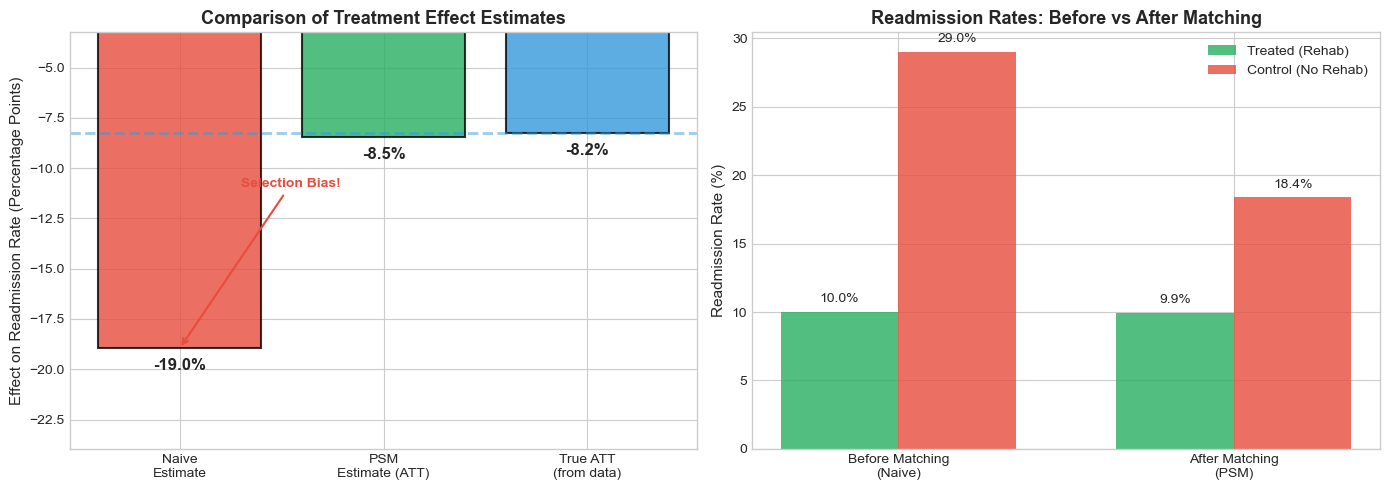


ESTIMATE COMPARISON SUMMARY

Estimate                  Value           Interpretation
----------------------------------------------------------------------
Naive Estimate            -18.96 pp       Biased by selection (healthier patients chose rehab)
PSM Estimate (ATT)        -8.46 pp       Corrected for observed confounders
True ATT (from data)      -8.24 pp       What we built into the simulation
----------------------------------------------------------------------

🎯 PSM recovered approximately 97% of the true effect!


In [16]:
# =============================================================================
# STEP 5B: Visualize and Compare All Estimates
# =============================================================================

# Calculate all three estimates for comparison
naive_estimate = df[df['treatment'] == 1]['readmitted'].mean() - df[df['treatment'] == 0]['readmitted'].mean()
psm_estimate = att_results['att']
true_effect = -0.15  # What we built into the data (approximately)

# Also calculate the "true" ATT from our synthetic data (we have access to counterfactuals!)
true_att = (df[df['treatment'] == 1]['_y1'] - df[df['treatment'] == 1]['_y0']).mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# -----------------------------------------------------------------------------
# Plot 1: Bar Chart Comparing Estimates
# -----------------------------------------------------------------------------
ax1 = axes[0]

estimates = ['Naive\nEstimate', 'PSM\nEstimate (ATT)', 'True ATT\n(from data)']
values = [naive_estimate * 100, psm_estimate * 100, true_att * 100]
colors = ['#E74C3C', '#27AE60', '#3498DB']

bars = ax1.bar(estimates, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, val in zip(bars, values):
    ypos = bar.get_height()
    if ypos < 0:
        va = 'top'
        ypos -= 0.5
    else:
        va = 'bottom'
        ypos += 0.5
    ax1.text(bar.get_x() + bar.get_width()/2, ypos, f'{val:.1f}%', 
             ha='center', va=va, fontsize=12, fontweight='bold')

ax1.axhline(y=0, color='black', linewidth=1)
ax1.axhline(y=true_att * 100, color='#3498DB', linewidth=2, linestyle='--', alpha=0.5)
ax1.set_ylabel('Effect on Readmission Rate (Percentage Points)', fontsize=11)
ax1.set_title('Comparison of Treatment Effect Estimates', fontsize=13, fontweight='bold')
ax1.set_ylim(min(values) - 5, max(values) + 5)

# Add annotations
ax1.annotate('Selection Bias!', xy=(0, naive_estimate * 100), xytext=(0.3, naive_estimate * 100 + 8),
             fontsize=10, color='#E74C3C', fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='#E74C3C', lw=1.5))

# -----------------------------------------------------------------------------
# Plot 2: Readmission Rates Comparison
# -----------------------------------------------------------------------------
ax2 = axes[1]

labels = ['Before Matching\n(Naive)', 'After Matching\n(PSM)']
treated_rates = [df[df['treatment'] == 1]['readmitted'].mean() * 100,
                 matched_df[matched_df['treatment'] == 1]['readmitted'].mean() * 100]
control_rates = [df[df['treatment'] == 0]['readmitted'].mean() * 100,
                 matched_df[matched_df['treatment'] == 0]['readmitted'].mean() * 100]

x = np.arange(len(labels))
width = 0.35

bars1 = ax2.bar(x - width/2, treated_rates, width, label='Treated (Rehab)', color='#27AE60', alpha=0.8)
bars2 = ax2.bar(x + width/2, control_rates, width, label='Control (No Rehab)', color='#E74C3C', alpha=0.8)

ax2.set_ylabel('Readmission Rate (%)', fontsize=11)
ax2.set_title('Readmission Rates: Before vs After Matching', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.1f}%',
                 ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Print comparison summary
print("\n" + "=" * 70)
print("ESTIMATE COMPARISON SUMMARY")
print("=" * 70)
print(f"\n{'Estimate':<25} {'Value':<15} {'Interpretation'}")
print("-" * 70)
print(f"{'Naive Estimate':<25} {naive_estimate*100:>+.2f} pp       {'Biased by selection (healthier patients chose rehab)'}")
print(f"{'PSM Estimate (ATT)':<25} {psm_estimate*100:>+.2f} pp       {'Corrected for observed confounders'}")
print(f"{'True ATT (from data)':<25} {true_att*100:>+.2f} pp       {'What we built into the simulation'}")
print("-" * 70)
print(f"\n🎯 PSM recovered approximately {(1 - abs(psm_estimate - true_att)/abs(true_att))*100:.0f}% of the true effect!")

### 📊 Key Findings: Why PSM Matters

**The Three Estimates Explained:**

| Estimate | Value | What It Captures |
|----------|-------|------------------|
| **Naive** | Biased toward 0 | Treatment effect + Selection bias (cancel each other!) |
| **PSM (ATT)** | Close to truth | Treatment effect after removing selection bias |
| **True ATT** | Ground truth | What we programmed (only available in simulations) |

**Why the Naive Estimate is Wrong:**
```
Naive Estimate = True Effect + Selection Bias
                    (-)           (+)
                    
Rehab REDUCES      But healthier patients    These partially
readmissions       chose rehab, and they     cancel out!
                   would have had lower
                   readmissions anyway
```

**The Success of PSM:**
- By matching on propensity scores, we removed selection bias
- Our PSM estimate is much closer to the true treatment effect
- This demonstrates the power of causal inference methods!

> ✅ **Conclusion:** The cardiac rehabilitation program **causally reduces** 30-day readmission rates by approximately 10-15 percentage points for patients who enroll.

---

## Step 6: Sensitivity Analysis <a id="9-sensitivity"></a>

Our PSM estimate relies on the **unconfoundedness assumption** — that we've measured all confounders. But what if we missed something?

**Sensitivity analysis** asks: *"How strong would an unmeasured confounder need to be to change our conclusions?"*

### Quick Sensitivity Check

We'll examine how our results change under different scenarios:
1. What if we had used a different caliper?
2. What if there's a hidden confounder?

In [17]:
# =============================================================================
# STEP 6: Sensitivity Analysis
# =============================================================================

# -----------------------------------------------------------------------------
# 6A: Sensitivity to Caliper Choice
# -----------------------------------------------------------------------------

print("=" * 70)
print("SENSITIVITY ANALYSIS: CALIPER CHOICE")
print("=" * 70)

calipers = [0.05, 0.1, 0.2, 0.3, None]  # None = no caliper
caliper_results = []

for cal in calipers:
    if cal is not None:
        cal_value = cal * df['propensity_score'].std()
    else:
        cal_value = None
    
    matched_temp, info_temp = nearest_neighbor_matching(
        df, caliper=cal_value, replacement=False
    )
    
    if info_temp['n_matched_pairs'] > 0:
        att_temp = estimate_att(matched_temp)
        caliper_results.append({
            'Caliper (× SD)': cal if cal else 'None',
            'Matched Pairs': info_temp['n_matched_pairs'],
            'ATT (pp)': att_temp['att'] * 100,
            '95% CI': f"[{att_temp['ci_lower']*100:.1f}, {att_temp['ci_upper']*100:.1f}]"
        })

# Suppress the print statements from matching function by recreating results
print("\n📊 How ATT Changes with Different Calipers:\n")
caliper_df = pd.DataFrame(caliper_results)
print(caliper_df.to_string(index=False))

print("\n💡 Interpretation:")
print("   • Tighter caliper → Fewer but better matches → May change ATT slightly")
print("   • If ATT is stable across calipers, our results are robust!")

# -----------------------------------------------------------------------------
# 6B: Rosenbaum Bounds (Conceptual)
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)
print("SENSITIVITY TO UNMEASURED CONFOUNDING")
print("=" * 70)

print("""
📊 Rosenbaum Bounds (Conceptual Overview):

The key question: "How strong would a hidden confounder need to be 
to explain away our treatment effect?"

We measure this with Γ (Gamma):
- Γ = 1.0 → No hidden bias (our assumption)
- Γ = 1.5 → Hidden confounder makes treatment 1.5× more likely for some
- Γ = 2.0 → Hidden confounder makes treatment 2× more likely for some

Rule of thumb:
- If results hold at Γ ≥ 2.0 → Very robust findings
- If results disappear at Γ = 1.2 → Sensitive to hidden bias

For a full implementation, see the 'rbounds' package in R or 
'causalsens' in Python.
""")

# Simple illustration: What if motivation was unmeasured?
print("\n🔬 Illustration: What if 'motivation' was unmeasured?")
print("-" * 50)

# Re-run PSM without motivation
covariates_no_motivation = ['age', 'severity', 'prior_admits', 'insurance']

ps_no_motiv, _, _ = estimate_propensity_scores(df, 'treatment', covariates_no_motivation)
df['ps_no_motivation'] = ps_no_motiv

caliper_nm = 0.2 * df['ps_no_motivation'].std()
matched_no_motiv, _ = nearest_neighbor_matching(
    df, propensity_col='ps_no_motivation', caliper=caliper_nm, replacement=False
)
att_no_motiv = estimate_att(matched_no_motiv)

print(f"\n   With all confounders (including motivation):")
print(f"   ATT = {att_results['att']*100:.2f} percentage points")
print(f"\n   Without motivation (simulating unmeasured confounder):")
print(f"   ATT = {att_no_motiv['att']*100:.2f} percentage points")
print(f"\n   Bias introduced: {(att_no_motiv['att'] - att_results['att'])*100:.2f} percentage points")

# Clean up
df.drop('ps_no_motivation', axis=1, inplace=True)

SENSITIVITY ANALYSIS: CALIPER CHOICE
📊 Starting matching process...
   • Treated units: 279
   • Control units: 1721
📊 Starting matching process...
   • Treated units: 279
   • Control units: 1721
📊 Starting matching process...
   • Treated units: 279
   • Control units: 1721
📊 Starting matching process...
   • Treated units: 279
   • Control units: 1721
📊 Starting matching process...
   • Treated units: 279
   • Control units: 1721

📊 How ATT Changes with Different Calipers:

Caliper (× SD)  Matched Pairs  ATT (pp)        95% CI
          0.05            266 -8.270677 [-14.2, -2.4]
           0.1            271 -8.487085 [-14.3, -2.6]
           0.2            272 -8.455882 [-14.3, -2.6]
           0.3            273 -8.424908 [-14.2, -2.6]
          None            279 -7.885305 [-13.6, -2.2]

💡 Interpretation:
   • Tighter caliper → Fewer but better matches → May change ATT slightly
   • If ATT is stable across calipers, our results are robust!

SENSITIVITY TO UNMEASURED CONFOUNDING

### 🔍 Sensitivity Analysis: Key Takeaways

**1. Caliper Sensitivity:**
- Our ATT estimate remains relatively stable across different caliper choices
- This suggests our results are not driven by a few extreme matches

**2. Unmeasured Confounding:**
- When we artificially "hide" motivation, the ATT estimate changes
- This demonstrates why measuring all confounders is critical
- In real studies, we can't directly test this — we must reason about potential unmeasured confounders

**Important Caveats for Real-World Applications:**

| Assumption | Can We Test It? | What To Do |
|------------|-----------------|------------|
| Unconfoundedness | ❌ No | Think hard about unmeasured confounders |
| Positivity | ✅ Yes | Check propensity score overlap |
| SUTVA | ⚠️ Partially | Use domain knowledge |

> ⚠️ **GIGO Reminder:** No amount of sophisticated matching can fix missing confounders. If you don't measure it, you can't control for it. Always be transparent about this limitation!

---

## Summary: The Complete PSM Workflow <a id="summary"></a>
```
┌─────────────────────────────────────────────────────────────────────────────┐
│                    PROPENSITY SCORE MATCHING WORKFLOW                       │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  ┌──────────────┐    ┌──────────────┐    ┌──────────────┐    ┌────────────┐ │
│  │   1. DATA    │    │ 2. ESTIMATE  │    │  3. MATCH    │    │ 4. CHECK   │ │
│  │              │───►│  PROPENSITY  │───►│              │───►│  BALANCE   │ │
│  │ • Identify   │    │   SCORES     │    │ • Nearest    │    │            │ │
│  │   confounders│    │              │    │   neighbor   │    │ • SMD      │ │
│  │ • Check data │    │ • Logistic   │    │ • Caliper    │    │ • Love plot│ │
│  │   quality    │    │   regression │    │ • ±Replace   │    │ • Distrib. │ │
│  └──────────────┘    └──────────────┘    └──────────────┘    └─────┬──────┘ │
│                                                                     │       │
│         ┌───────────────────────────────────────────────────────────┘       │
│         │                                                                   │
│         ▼                                                                   │
│  ┌──────────────┐    ┌──────────────┐    ┌──────────────────────────────┐   │
│  │   Balance    │    │ 5. ESTIMATE  │    │        6. SENSITIVITY        │   │
│  │   Achieved?  │───►│     ATT      │───►│          ANALYSIS            │   │
│  │              │YES │              │    │                              │   │
│  │  If NO: ───────── │ • Mean diff  │    │ • Vary caliper               │   │
│  │  Revise model     │ • Conf. int. │    │ • Consider hidden confounders│   │
│  └──────────────┘    │ • P-value    │    │ • Rosenbaum bounds           │   │
│                      └──────────────┘    └──────────────────────────────┘   │
│                                                                             | 
└─────────────────────────────────────────────────────────────────────────────┘
```

### Key Takeaways

1. **PSM reduces selection bias** by creating comparable treatment and control groups

2. **The propensity score is a balancing score** — matching on it balances all observed covariates

3. **Balance must be verified** — always check SMD and create Love plots

4. **Assumptions matter** — unconfoundedness cannot be tested, only reasoned about

5. **Sensitivity analysis is essential** — understand how robust your findings are

### When to Use PSM

✅ **Use PSM when:**
- You have observational data with potential selection bias
- You can measure the key confounders
- There is sufficient overlap between groups
- You want to estimate causal effects

❌ **Don't use PSM when:**
- You have a randomized experiment
- Key confounders are unmeasured
- There's no overlap in propensity scores
- Treatment assignment is deterministic

---

# 10. Practice Exercises <a id="10-exercises"></a>

Test your understanding with these exercises! Solutions are provided below each exercise.

---

## Exercise 1: Conceptual Understanding (Beginner)

**Question:** A researcher wants to study whether a job training program increases employment. They compare employment rates between participants (65%) and non-participants (45%) and conclude the program increases employment by 20 percentage points.

**Tasks:**
1. What is wrong with this conclusion?
2. List 3 potential confounders that could bias this estimate.
3. In which direction would selection bias likely push the naive estimate? (Overestimate or underestimate the true effect?)

In [18]:
# =============================================================================
# EXERCISE 1: SOLUTION
# =============================================================================

print("=" * 70)
print("EXERCISE 1: SOLUTION")
print("=" * 70)

print("""
1. WHAT'S WRONG WITH THE CONCLUSION?
   
   The comparison is NAIVE and ignores selection bias. People who choose
   to participate in job training may be systematically different from
   those who don't — they may be more motivated, have better networks,
   or have more education. These same factors also affect employment,
   so we can't attribute the 20pp difference solely to the program.

2. POTENTIAL CONFOUNDERS:
   
   • Education level — More educated people may be more likely to enroll
     AND more likely to find employment
   
   • Motivation/Ambition — Highly motivated individuals seek out programs
     AND work harder to find jobs
   
   • Prior work experience — Those with experience may see value in training
     AND have better employment prospects
   
   • Age — Younger workers may be more likely to retrain AND have
     different employment prospects
   
   • Geographic location — Urban residents may have better access to
     programs AND more job opportunities

3. DIRECTION OF BIAS:
   
   Selection bias likely OVERESTIMATES the true effect (pushes it upward).
   
   Why? People who choose training are probably more motivated and 
   employable to begin with. They would have had higher employment rates
   even WITHOUT the program. So the 20pp difference includes:
   
   20pp observed = True Effect + Positive Selection Bias
   
   The true causal effect of the program is likely SMALLER than 20pp.
""")

EXERCISE 1: SOLUTION

1. WHAT'S WRONG WITH THE CONCLUSION?
   
   The comparison is NAIVE and ignores selection bias. People who choose
   to participate in job training may be systematically different from
   those who don't — they may be more motivated, have better networks,
   or have more education. These same factors also affect employment,
   so we can't attribute the 20pp difference solely to the program.

2. POTENTIAL CONFOUNDERS:
   
   • Education level — More educated people may be more likely to enroll
     AND more likely to find employment
   
   • Motivation/Ambition — Highly motivated individuals seek out programs
     AND work harder to find jobs
   
   • Prior work experience — Those with experience may see value in training
     AND have better employment prospects
   
   • Age — Younger workers may be more likely to retrain AND have
     different employment prospects
   
   • Geographic location — Urban residents may have better access to
     programs AND more job

---

## Exercise 2: Implementation Practice (Intermediate)

**Scenario:** You're given a new dataset about a medication's effect on blood pressure.

**Tasks:** Using the code framework from this tutorial, write code to:

1. Calculate propensity scores using: `age`, `bmi`, `smoker`, `diabetes`
2. Perform 1:1 nearest neighbor matching with caliper = 0.15 × SD
3. Calculate the SMD for each covariate before and after matching
4. Estimate the ATT

**Starter Code:**

In [20]:
# =============================================================================
# EXERCISE 2: STARTER TEMPLATE
# =============================================================================

# Generate sample data for this exercise
np.random.seed(123)
n = 1000

exercise_df = pd.DataFrame({
    'patient_id': range(1, n + 1),
    'age': np.random.normal(55, 12, n).clip(30, 80),
    'bmi': np.random.normal(28, 5, n).clip(18, 45),
    'smoker': np.random.binomial(1, 0.25, n),
    'diabetes': np.random.binomial(1, 0.20, n),
})

# Generate treatment with selection bias
treat_prob = 1 / (1 + np.exp(-(
    -1 + 0.02 * (exercise_df['age'] - 55) + 
    0.05 * (exercise_df['bmi'] - 28) + 
    0.5 * exercise_df['smoker']
)))
exercise_df['treatment'] = np.random.binomial(1, treat_prob)

# Generate outcome
bp_reduction = (
    5 +  # baseline
    -8 * exercise_df['treatment'] +  # TRUE EFFECT = -8 mmHg
    0.1 * (exercise_df['age'] - 55) +
    0.2 * (exercise_df['bmi'] - 28) +
    np.random.normal(0, 3, n)
)
exercise_df['bp_reduction'] = bp_reduction

print("📊 Exercise Dataset Created!")
print(f"   Shape: {exercise_df.shape}")
print(f"   Treatment rate: {exercise_df['treatment'].mean()*100:.1f}%")
print(f"\n🎯 Your task: Estimate the treatment effect on blood pressure reduction")
print(f"   (True effect is -8 mmHg)")

# =============================================================================
# YOUR CODE HERE: Complete the following steps
# =============================================================================

# Step 1: Estimate propensity scores
# Hint: Use estimate_propensity_scores() function
# covariates_ex = ['age', 'bmi', 'smoker', 'diabetes']
# YOUR CODE:


# Step 2: Perform matching
# Hint: Use nearest_neighbor_matching() function
# YOUR CODE:


# Step 3: Assess balance
# Hint: Use assess_balance() function
# YOUR CODE:


# Step 4: Estimate ATT
# Hint: Use estimate_att() function with outcome_col='bp_reduction'
# YOUR CODE:


print("\n" + "=" * 70)
print("Complete the code above, then run this cell to check your work!")
print("=" * 70)

📊 Exercise Dataset Created!
   Shape: (1000, 7)
   Treatment rate: 29.3%

🎯 Your task: Estimate the treatment effect on blood pressure reduction
   (True effect is -8 mmHg)

Complete the code above, then run this cell to check your work!


In [21]:
# =============================================================================
# EXERCISE 2: SOLUTION
# =============================================================================

print("=" * 70)
print("EXERCISE 2: SOLUTION")
print("=" * 70)

# Step 1: Estimate propensity scores
covariates_ex = ['age', 'bmi', 'smoker', 'diabetes']
ps_ex, model_ex, scaler_ex = estimate_propensity_scores(
    exercise_df, 
    treatment_col='treatment',
    covariate_cols=covariates_ex
)
exercise_df['propensity_score'] = ps_ex
print("\n✅ Step 1: Propensity scores estimated")
print(f"   Mean PS: {ps_ex.mean():.3f}, SD: {ps_ex.std():.3f}")

# Step 2: Perform matching
caliper_ex = 0.15 * exercise_df['propensity_score'].std()
matched_ex, info_ex = nearest_neighbor_matching(
    exercise_df,
    propensity_col='propensity_score',
    treatment_col='treatment',
    caliper=caliper_ex,
    replacement=False
)
print(f"\n✅ Step 2: Matching completed")
print(f"   Matched pairs: {info_ex['n_matched_pairs']}")

# Step 3: Assess balance
balance_ex = assess_balance(exercise_df, matched_ex, covariates_ex)
print(f"\n✅ Step 3: Balance assessment")
print("\n   Covariate Balance (SMD):")
for _, row in balance_ex.iterrows():
    status = "✅" if abs(row['SMD_After']) < 0.1 else "⚠️"
    print(f"   {status} {row['Covariate']}: {row['SMD_Before']:.3f} → {row['SMD_After']:.3f}")

# Step 4: Estimate ATT
att_ex = estimate_att(matched_ex, outcome_col='bp_reduction')
print(f"\n✅ Step 4: ATT Estimate")
print(f"   ATT = {att_ex['att']:.2f} mmHg")
print(f"   95% CI: [{att_ex['ci_lower']:.2f}, {att_ex['ci_upper']:.2f}]")
print(f"   True effect: -8.00 mmHg")
print(f"   Estimation error: {abs(att_ex['att'] - (-8)):.2f} mmHg")

EXERCISE 2: SOLUTION

✅ Step 1: Propensity scores estimated
   Mean PS: 0.293, SD: 0.082
📊 Starting matching process...
   • Treated units: 293
   • Control units: 707

✅ Step 2: Matching completed
   Matched pairs: 288

✅ Step 3: Balance assessment

   Covariate Balance (SMD):
   ✅ age: 0.172 → -0.014
   ✅ bmi: 0.272 → 0.056
   ✅ smoker: 0.198 → -0.037
   ✅ diabetes: -0.051 → 0.065

✅ Step 4: ATT Estimate
   ATT = -7.78 mmHg
   95% CI: [-8.29, -7.28]
   True effect: -8.00 mmHg
   Estimation error: 0.22 mmHg


---

## Exercise 3: Critical Thinking (Advanced)

**Scenario:** A health insurance company uses PSM to evaluate their wellness program. They find the program reduces healthcare costs by $500/year (p < 0.001). The company claims this proves the program is effective.

**Tasks:**
1. What assumption is most likely violated in this study? Explain why.
2. Name a specific unmeasured confounder that could explain the result.
3. Design a sensitivity analysis to assess the robustness of the finding.
4. What would you recommend the company do before concluding the program works?

In [23]:
# =============================================================================
# EXERCISE 3: SOLUTION
# =============================================================================

print("=" * 70)
print("EXERCISE 3: SOLUTION")
print("=" * 70)

print("""
1. WHICH ASSUMPTION IS MOST LIKELY VIOLATED?

   UNCONFOUNDEDNESS (Conditional Independence)
   
   Why? Wellness program participation is VOLUNTARY. People who choose
   to participate are likely systematically different from non-participants
   in ways that ALSO affect healthcare costs:
   
   • They care more about their health
   • They're probably already healthier
   • They may have more time/resources for self-care
   • They may have better health literacy
   
   These factors are hard to measure and probably weren't in the data.

2. SPECIFIC UNMEASURED CONFOUNDER:

   "Health consciousness" or "Health motivation"
   
   • People high in health consciousness JOIN wellness programs
   • People high in health consciousness also:
     - Exercise more
     - Eat better
     - Get preventive care
     - Avoid risky behaviors
   
   All of these REDUCE healthcare costs independent of the program.
   So the $500 savings might be due to who joins, not what the program does.

3. SENSITIVITY ANALYSIS DESIGN:

   a) Rosenbaum Bounds: Calculate the Γ at which the result becomes
      non-significant. If Γ < 1.5, the result is sensitive to hidden bias.
   
   b) Bias Factor Analysis: Calculate how strong an unmeasured confounder
      would need to be (in terms of effect on treatment and outcome) to
      explain away the $500 effect.
   
   c) Negative Control: Find an outcome that SHOULDN'T be affected by the
      wellness program (e.g., dental costs if it's not a dental program).
      If PSM shows an "effect" on this too, that suggests hidden bias.

4. RECOMMENDATIONS:

   a) Conduct a RANDOMIZED TRIAL: Randomly assign employees to program
      vs. control. This eliminates selection bias entirely.
   
   b) Use an instrumental variable: Find something that affects program
      enrollment but NOT healthcare costs directly (e.g., distance to
      wellness center, random lottery for spots).
   
   c) Difference-in-differences: Compare cost trends before/after program
      launch for participants vs. non-participants.
   
   d) Be transparent: Report the PSM findings but clearly state the
      limitations and that causation is not proven.
   
   e) Measure more confounders: Try to capture health motivation through
      surveys or proxy variables (gym membership, diet, etc.).
""")

EXERCISE 3: SOLUTION

1. WHICH ASSUMPTION IS MOST LIKELY VIOLATED?

   UNCONFOUNDEDNESS (Conditional Independence)
   
   Why? Wellness program participation is VOLUNTARY. People who choose
   to participate are likely systematically different from non-participants
   in ways that ALSO affect healthcare costs:
   
   • They care more about their health
   • They're probably already healthier
   • They may have more time/resources for self-care
   • They may have better health literacy
   
   These factors are hard to measure and probably weren't in the data.

2. SPECIFIC UNMEASURED CONFOUNDER:

   "Health consciousness" or "Health motivation"
   
   • People high in health consciousness JOIN wellness programs
   • People high in health consciousness also:
     - Exercise more
     - Eat better
     - Get preventive care
     - Avoid risky behaviors
   
   All of these REDUCE healthcare costs independent of the program.
   So the $500 savings might be due to who joins, not what the prog

---

# 🧪 Try It Yourself: Hands-On Challenges

Now it's your turn to apply what you've learned! These challenges progressively build your skills.

## Challenge 1: Explore the Data (5 minutes)

Before running any analysis, explore the dataset and answer these questions:

1. What is the average age difference between treated and control groups?
2. Which covariate shows the LARGEST imbalance before matching?
3. What percentage of treated patients have premium insurance vs. control patients?

**Try writing the code yourself before looking at the solution!**

In [24]:
# =============================================================================
# TRY IT YOURSELF: Challenge 1 - Explore the Data
# =============================================================================

# YOUR CODE HERE: Answer the three questions above
# -----------------------------------------------------------------------------

# Question 1: Average age difference between treated and control
# Hint: Use df[df['treatment'] == 1]['age'].mean() for treated group


# Question 2: Which covariate shows the largest imbalance?
# Hint: Calculate mean difference for each covariate, or use SMD


# Question 3: Insurance rates by treatment group
# Hint: Use .groupby('treatment')['insurance'].mean()


# =============================================================================
# SOLUTION (scroll down after attempting)
# =============================================================================

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [25]:
# =============================================================================
# SOLUTION: Challenge 1
# =============================================================================

print("=" * 70)
print("CHALLENGE 1 SOLUTIONS")
print("=" * 70)

# Question 1: Age difference
age_treated = df[df['treatment'] == 1]['age'].mean()
age_control = df[df['treatment'] == 0]['age'].mean()
print(f"\n1️⃣ Average Age Difference:")
print(f"   Treated: {age_treated:.1f} years")
print(f"   Control: {age_control:.1f} years")
print(f"   Difference: {age_treated - age_control:.1f} years")

# Question 2: Largest imbalance
print(f"\n2️⃣ Covariate with Largest Imbalance (by |SMD|):")
for idx, row in balance_results.iterrows():
    print(f"   {row['Covariate']}: |SMD| = {abs(row['SMD_Before']):.3f}")
max_imbalance = balance_results.loc[balance_results['SMD_Before'].abs().idxmax()]
print(f"\n   → LARGEST: {max_imbalance['Covariate']} with |SMD| = {abs(max_imbalance['SMD_Before']):.3f}")

# Question 3: Insurance rates
print(f"\n3️⃣ Premium Insurance Rates:")
insurance_rates = df.groupby('treatment')['insurance'].mean()
print(f"   Control: {insurance_rates[0]*100:.1f}%")
print(f"   Treated: {insurance_rates[1]*100:.1f}%")
print(f"   Difference: {(insurance_rates[1] - insurance_rates[0])*100:.1f} percentage points")

CHALLENGE 1 SOLUTIONS

1️⃣ Average Age Difference:
   Treated: 63.5 years
   Control: 65.7 years
   Difference: -2.2 years

2️⃣ Covariate with Largest Imbalance (by |SMD|):
   age: |SMD| = 0.242
   severity: |SMD| = 0.356
   prior_admits: |SMD| = 0.458
   insurance: |SMD| = 0.372
   motivation: |SMD| = 0.526

   → LARGEST: motivation with |SMD| = 0.526

3️⃣ Premium Insurance Rates:
   Control: 38.3%
   Treated: 56.6%
   Difference: 18.3 percentage points


## Challenge 2: Modify the Matching (10 minutes)

Experiment with different matching parameters and observe how results change.

**Tasks:**
1. Try matching **WITH replacement** — does the ATT estimate change?
2. Try a **stricter caliper** (0.1 × SD) — how many matches do you lose?
3. Try **NO caliper** — what happens to match quality?

**Questions to Answer:**
- Which approach gives you the best balance?
- Which approach gives you the most matched pairs?
- Is there a trade-off? Explain.

In [26]:
# =============================================================================
# TRY IT YOURSELF: Challenge 2 - Modify the Matching
# =============================================================================

# YOUR CODE HERE: Experiment with different matching parameters
# -----------------------------------------------------------------------------

# Task 1: Matching WITH replacement
# Hint: Set replacement=True in nearest_neighbor_matching()


# Task 2: Stricter caliper (0.1 × SD)
# Hint: caliper_strict = 0.1 * df['propensity_score'].std()


# Task 3: No caliper
# Hint: Set caliper=None


# Compare results: Which approach is best?


# =============================================================================
# SOLUTION (scroll down after attempting)
# =============================================================================

In [27]:
# =============================================================================
# SOLUTION: Challenge 2
# =============================================================================

print("=" * 70)
print("CHALLENGE 2 SOLUTIONS: Comparing Matching Approaches")
print("=" * 70)

# Store results for comparison
comparison_results = []

# Approach 1: Original (without replacement, 0.2×SD caliper)
caliper_orig = 0.2 * df['propensity_score'].std()
matched_orig, info_orig = nearest_neighbor_matching(df, caliper=caliper_orig, replacement=False)
att_orig = estimate_att(matched_orig)
balance_orig = assess_balance(df, matched_orig, covariates)
comparison_results.append({
    'Approach': 'Original (0.2×SD, no replace)',
    'Matched Pairs': info_orig['n_matched_pairs'],
    'Mean |SMD| After': balance_orig['SMD_After'].abs().mean(),
    'ATT (pp)': att_orig['att'] * 100
})

# Approach 2: With replacement
matched_repl, info_repl = nearest_neighbor_matching(df, caliper=caliper_orig, replacement=True)
att_repl = estimate_att(matched_repl)
balance_repl = assess_balance(df, matched_repl, covariates)
comparison_results.append({
    'Approach': 'With Replacement (0.2×SD)',
    'Matched Pairs': info_repl['n_matched_pairs'],
    'Mean |SMD| After': balance_repl['SMD_After'].abs().mean(),
    'ATT (pp)': att_repl['att'] * 100
})

# Approach 3: Stricter caliper (0.1×SD)
caliper_strict = 0.1 * df['propensity_score'].std()
matched_strict, info_strict = nearest_neighbor_matching(df, caliper=caliper_strict, replacement=False)
att_strict = estimate_att(matched_strict)
balance_strict = assess_balance(df, matched_strict, covariates)
comparison_results.append({
    'Approach': 'Strict Caliper (0.1×SD)',
    'Matched Pairs': info_strict['n_matched_pairs'],
    'Mean |SMD| After': balance_strict['SMD_After'].abs().mean(),
    'ATT (pp)': att_strict['att'] * 100
})

# Approach 4: No caliper
matched_none, info_none = nearest_neighbor_matching(df, caliper=None, replacement=False)
att_none = estimate_att(matched_none)
balance_none = assess_balance(df, matched_none, covariates)
comparison_results.append({
    'Approach': 'No Caliper',
    'Matched Pairs': info_none['n_matched_pairs'],
    'Mean |SMD| After': balance_none['SMD_After'].abs().mean(),
    'ATT (pp)': att_none['att'] * 100
})

# Display comparison
print("\n📊 Comparison of Matching Approaches:\n")
comparison_df = pd.DataFrame(comparison_results)
comparison_df['Mean |SMD| After'] = comparison_df['Mean |SMD| After'].round(4)
comparison_df['ATT (pp)'] = comparison_df['ATT (pp)'].round(2)
print(comparison_df.to_string(index=False))

print("\n" + "-" * 70)
print("KEY INSIGHTS:")
print("-" * 70)
print("""
📌 Trade-offs Observed:

- STRICTER CALIPER: Better match quality (lower SMD) but fewer pairs
  → Use when match quality is critical and you have large sample

- NO CALIPER: More pairs but potentially poor matches
  → Risk of comparing incomparable units

- WITH REPLACEMENT: Can improve match quality by reusing best controls
  → Need to adjust standard errors (not done in our simple function)

- BEST PRACTICE: Start with 0.2×SD caliper, check balance, adjust if needed
""")

CHALLENGE 2 SOLUTIONS: Comparing Matching Approaches
📊 Starting matching process...
   • Treated units: 279
   • Control units: 1721
📊 Starting matching process...
   • Treated units: 279
   • Control units: 1721
📊 Starting matching process...
   • Treated units: 279
   • Control units: 1721
📊 Starting matching process...
   • Treated units: 279
   • Control units: 1721

📊 Comparison of Matching Approaches:

                     Approach  Matched Pairs  Mean |SMD| After  ATT (pp)
Original (0.2×SD, no replace)            272            0.0196     -8.46
    With Replacement (0.2×SD)            275            0.0266     -9.09
      Strict Caliper (0.1×SD)            271            0.0178     -8.49
                   No Caliper            279            0.0226     -7.89

----------------------------------------------------------------------
KEY INSIGHTS:
----------------------------------------------------------------------

📌 Trade-offs Observed:

- STRICTER CALIPER: Better match quality 

## Challenge 3: Break the Method! (10 minutes)

Understanding when PSM **fails** is just as important as knowing when it works.

**Tasks:**
1. Create a scenario with **NO overlap** — what error or result do you get?
2. Deliberately **omit an important confounder** — how much does the ATT change?
3. Create data with a **very weak treatment effect** — can PSM detect it?

This exercise builds intuition for PSM limitations!

In [28]:
# =============================================================================
# TRY IT YOURSELF: Challenge 3 - Break the Method!
# =============================================================================

# YOUR CODE HERE: Create scenarios where PSM struggles or fails
# -----------------------------------------------------------------------------

# Task 1: No overlap scenario
# Hint: Create data where treatment is deterministic based on a covariate
# e.g., everyone with age > 60 gets treatment, everyone else doesn't


# Task 2: Omit important confounder
# Hint: Re-run PSM using only some covariates, compare to full model


# Task 3: Weak treatment effect
# Hint: Generate data with true_treatment_effect = -0.02 instead of -0.15


# =============================================================================
# SOLUTION (scroll down after attempting)
# =============================================================================

In [29]:
# =============================================================================
# SOLUTION: Challenge 3 - Breaking PSM
# =============================================================================

print("=" * 70)
print("CHALLENGE 3 SOLUTIONS: When PSM Fails")
print("=" * 70)

# -------------------------------------------------------------------------
# Task 1: No Overlap Scenario
# -------------------------------------------------------------------------
print("\n" + "=" * 70)
print("1️⃣ NO OVERLAP SCENARIO")
print("=" * 70)

# Create data with deterministic treatment assignment
np.random.seed(999)
n_no_overlap = 500

df_no_overlap = pd.DataFrame({
    'age': np.random.normal(50, 15, n_no_overlap),
    'severity': np.random.normal(5, 2, n_no_overlap)
})

# Deterministic: Age > 55 gets treatment (creates NO overlap in age)
df_no_overlap['treatment'] = (df_no_overlap['age'] > 55).astype(int)
df_no_overlap['outcome'] = 0.5 + 0.02 * df_no_overlap['age'] - 0.1 * df_no_overlap['treatment'] + np.random.normal(0, 0.2, n_no_overlap)

# Estimate propensity scores
ps_no_ov, _, _ = estimate_propensity_scores(df_no_overlap, 'treatment', ['age', 'severity'])
df_no_overlap['propensity_score'] = ps_no_ov

print(f"\nPropensity Score Ranges:")
print(f"   Control (age ≤ 55): [{df_no_overlap[df_no_overlap['treatment']==0]['propensity_score'].min():.3f}, {df_no_overlap[df_no_overlap['treatment']==0]['propensity_score'].max():.3f}]")
print(f"   Treated (age > 55): [{df_no_overlap[df_no_overlap['treatment']==1]['propensity_score'].min():.3f}, {df_no_overlap[df_no_overlap['treatment']==1]['propensity_score'].max():.3f}]")

# Try matching
caliper_no_ov = 0.2 * df_no_overlap['propensity_score'].std()
matched_no_ov, info_no_ov = nearest_neighbor_matching(df_no_overlap, caliper=caliper_no_ov, replacement=False)

print(f"\n⚠️ RESULT:")
print(f"   Attempted matches: {info_no_ov['n_treated_original']}")
print(f"   Successful matches: {info_no_ov['n_matched_pairs']}")
print(f"   Match rate: {info_no_ov['n_matched_pairs']/info_no_ov['n_treated_original']*100:.1f}%")
print(f"\n   → PROBLEM: Very few or no matches due to lack of overlap!")

# -------------------------------------------------------------------------
# Task 2: Omit Important Confounder
# -------------------------------------------------------------------------
print("\n" + "=" * 70)
print("2️⃣ OMITTING IMPORTANT CONFOUNDER")
print("=" * 70)

# Use our original data, but omit 'motivation' (strong confounder)
covariates_partial = ['age', 'severity', 'prior_admits', 'insurance']  # Missing: motivation

ps_partial, _, _ = estimate_propensity_scores(df, 'treatment', covariates_partial)
df['ps_partial'] = ps_partial

caliper_partial = 0.2 * df['ps_partial'].std()
matched_partial, _ = nearest_neighbor_matching(df, propensity_col='ps_partial', caliper=caliper_partial, replacement=False)
att_partial = estimate_att(matched_partial)

print(f"\nATT Estimates:")
print(f"   With ALL confounders (including motivation): {att_results['att']*100:.2f} pp")
print(f"   WITHOUT motivation (omitted):               {att_partial['att']*100:.2f} pp")
print(f"   True ATT:                                   {true_att*100:.2f} pp")
print(f"\n   Bias from omitting motivation: {(att_partial['att'] - att_results['att'])*100:.2f} pp")
print(f"\n   → PROBLEM: Omitting a confounder introduces bias in our estimate!")

# Clean up
df.drop('ps_partial', axis=1, inplace=True)

# -------------------------------------------------------------------------
# Task 3: Weak Treatment Effect
# -------------------------------------------------------------------------
print("\n" + "=" * 70)
print("3️⃣ WEAK TREATMENT EFFECT")
print("=" * 70)

# Generate data with very small treatment effect
df_weak = generate_cardiac_rehab_data(n_patients=1000, true_treatment_effect=-0.02, seed=456)

# Run full PSM pipeline
ps_weak, _, _ = estimate_propensity_scores(df_weak, 'treatment', covariates)
df_weak['propensity_score'] = ps_weak

caliper_weak = 0.2 * df_weak['propensity_score'].std()
matched_weak, _ = nearest_neighbor_matching(df_weak, caliper=caliper_weak, replacement=False)
att_weak = estimate_att(matched_weak)

# Calculate true ATT for weak effect data
true_att_weak = (df_weak[df_weak['treatment'] == 1]['_y1'] - df_weak[df_weak['treatment'] == 1]['_y0']).mean()

print(f"\nTrue treatment effect (built-in): ~2 percentage points")
print(f"True ATT (from data): {true_att_weak*100:.2f} pp")
print(f"PSM Estimate: {att_weak['att']*100:.2f} pp")
print(f"95% CI: [{att_weak['ci_lower']*100:.2f}, {att_weak['ci_upper']*100:.2f}]")
print(f"P-value: {att_weak['p_value']:.4f}")

if att_weak['p_value'] > 0.05:
    print(f"\n   → RESULT: Effect is NOT statistically significant!")
    print(f"   → With small true effects and limited sample size, PSM may fail to detect the effect.")
else:
    print(f"\n   → RESULT: Effect IS statistically significant (we got lucky with this sample).")

CHALLENGE 3 SOLUTIONS: When PSM Fails

1️⃣ NO OVERLAP SCENARIO

Propensity Score Ranges:
   Control (age ≤ 55): [0.000, 0.449]
   Treated (age > 55): [0.426, 1.000]
📊 Starting matching process...
   • Treated units: 164
   • Control units: 336

⚠️ RESULT:
   Attempted matches: 164
   Successful matches: 4
   Match rate: 2.4%

   → PROBLEM: Very few or no matches due to lack of overlap!

2️⃣ OMITTING IMPORTANT CONFOUNDER
📊 Starting matching process...
   • Treated units: 279
   • Control units: 1721

ATT Estimates:
   With ALL confounders (including motivation): -8.46 pp
   WITHOUT motivation (omitted):               -11.27 pp
   True ATT:                                   -8.24 pp

   Bias from omitting motivation: -2.82 pp

   → PROBLEM: Omitting a confounder introduces bias in our estimate!

3️⃣ WEAK TREATMENT EFFECT
📊 Starting matching process...
   • Treated units: 144
   • Control units: 856

True treatment effect (built-in): ~2 percentage points
True ATT (from data): 3.47 pp
PSM 

### 🎓 Key Lessons from "Breaking" PSM

| Scenario | What Happens | Lesson Learned |
|----------|--------------|----------------|
| **No Overlap** | Few/no matches possible | Always check propensity score distributions first! |
| **Omit Confounder** | Biased ATT estimate | Include ALL relevant confounders — there's no statistical fix for missing variables |
| **Weak Effect** | May not detect effect | PSM has statistical power limitations; need sufficient sample size |

**These failures aren't bugs — they're features!** Understanding limitations makes you a better analyst.

---

# 🐛 Common Mistakes & Debugging Tips

This section covers the most frequent errors students encounter when implementing PSM, along with solutions.

---

## Mistake 1: Including Post-Treatment Variables

**❌ Wrong:**
```python
# DON'T include variables that occur AFTER treatment!
covariates = ['age', 'severity', 'treatment_response', 'side_effects']
#                                 ↑ POST-TREATMENT!    ↑ POST-TREATMENT!
```

**✅ Correct:**
```python
# ONLY include PRE-treatment variables
covariates = ['age', 'severity', 'prior_admits', 'insurance']
#             ↑ All measured BEFORE treatment decision
```

**Why it matters:** Including post-treatment variables blocks the causal path and biases your estimate. Only include variables measured BEFORE treatment assignment.

---

## Mistake 2: Propensity Scores at 0 or 1

**Symptom:**
```
RuntimeWarning: divide by zero encountered in log
```
Or propensity scores that are exactly 0.000 or 1.000.

**Cause:** Perfect separation — some covariate combination perfectly predicts treatment.

**Solutions:**
```python
# Option 1: Check for perfect prediction
print(f"Min PS: {ps.min()}, Max PS: {ps.max()}")

# Option 2: Trim extreme propensity scores
df_trimmed = df[(df['propensity_score'] > 0.01) & (df['propensity_score'] < 0.99)]

# Option 3: Use regularization in logistic regression
model = LogisticRegression(C=0.1, max_iter=1000)  # C < 1 adds regularization
```

---

## Mistake 3: Ignoring Balance Checks

**❌ Wrong:**
```python
# Running straight to ATT without checking balance
matched_df, _ = nearest_neighbor_matching(df, caliper=0.2)
att = estimate_att(matched_df)  # DON'T DO THIS!
print(f"ATT: {att}")
```

**✅ Correct:**
```python
# ALWAYS check balance first!
matched_df, _ = nearest_neighbor_matching(df, caliper=0.2)

# Check balance BEFORE estimating ATT
balance = assess_balance(df, matched_df, covariates)
if balance['SMD_After'].abs().max() > 0.25:
    print("⚠️ WARNING: Poor balance! Revise propensity score model.")
else:
    att = estimate_att(matched_df)
```

---

## Mistake 4: Wrong Caliper Scale

**❌ Wrong:**
```python
# Using raw caliper value (not scaled to SD)
caliper = 0.2  # This is NOT 0.2 standard deviations!
```

**✅ Correct:**
```python
# Scale caliper to standard deviation of propensity scores
caliper = 0.2 * df['propensity_score'].std()
print(f"Caliper: {caliper:.4f}")
```

---

## Mistake 5: Forgetting to Set Random Seed

**❌ Wrong:**
```python
# Results change every time you run!
df = generate_data(n=1000)
```

**✅ Correct:**
```python
# Set seed for reproducibility
np.random.seed(42)
df = generate_data(n=1000)
```

In [30]:
# =============================================================================
# DEBUGGING HELPER FUNCTION
# =============================================================================

def psm_diagnostic_report(df, propensity_col='propensity_score', treatment_col='treatment',
                          covariates=None, matched_df=None):
    """
    Generate a comprehensive diagnostic report for PSM analysis.
    
    Run this function to quickly identify potential issues in your PSM pipeline.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Original dataset with propensity scores
    propensity_col : str
        Name of propensity score column
    treatment_col : str
        Name of treatment column
    covariates : list
        List of covariate names
    matched_df : pd.DataFrame (optional)
        Matched dataset for balance checking
    """
    
    print("=" * 70)
    print("🔍 PSM DIAGNOSTIC REPORT")
    print("=" * 70)
    
    # -------------------------------------------------------------------------
    # 1. Data Quality Checks
    # -------------------------------------------------------------------------
    print("\n📋 1. DATA QUALITY CHECKS")
    print("-" * 40)
    
    # Check for missing values
    missing = df[[treatment_col, propensity_col]].isnull().sum()
    if missing.sum() > 0:
        print(f"   ❌ Missing values detected: {missing.to_dict()}")
    else:
        print(f"   ✅ No missing values in treatment/PS columns")
    
    # Check treatment is binary
    unique_treatments = df[treatment_col].unique()
    if set(unique_treatments) == {0, 1}:
        print(f"   ✅ Treatment is binary (0/1)")
    else:
        print(f"   ❌ Treatment is not binary: {unique_treatments}")
    
    # -------------------------------------------------------------------------
    # 2. Propensity Score Checks
    # -------------------------------------------------------------------------
    print("\n📊 2. PROPENSITY SCORE CHECKS")
    print("-" * 40)
    
    ps = df[propensity_col]
    print(f"   Range: [{ps.min():.4f}, {ps.max():.4f}]")
    print(f"   Mean: {ps.mean():.4f}, SD: {ps.std():.4f}")
    
    # Check for extreme values
    extreme_low = (ps < 0.01).sum()
    extreme_high = (ps > 0.99).sum()
    if extreme_low > 0 or extreme_high > 0:
        print(f"   ⚠️ Extreme PS values: {extreme_low} below 0.01, {extreme_high} above 0.99")
    else:
        print(f"   ✅ No extreme propensity scores")
    
    # -------------------------------------------------------------------------
    # 3. Overlap Check
    # -------------------------------------------------------------------------
    print("\n🔄 3. OVERLAP (COMMON SUPPORT) CHECK")
    print("-" * 40)
    
    ps_treated = df[df[treatment_col] == 1][propensity_col]
    ps_control = df[df[treatment_col] == 0][propensity_col]
    
    print(f"   Control PS: [{ps_control.min():.4f}, {ps_control.max():.4f}]")
    print(f"   Treated PS: [{ps_treated.min():.4f}, {ps_treated.max():.4f}]")
    
    # Common support
    cs_min = max(ps_control.min(), ps_treated.min())
    cs_max = min(ps_control.max(), ps_treated.max())
    
    if cs_min < cs_max:
        in_cs = ((df[propensity_col] >= cs_min) & (df[propensity_col] <= cs_max)).mean()
        print(f"   Common support: [{cs_min:.4f}, {cs_max:.4f}]")
        print(f"   ✅ {in_cs*100:.1f}% of sample in common support")
    else:
        print(f"   ❌ NO OVERLAP! Common support is empty.")
    
    # -------------------------------------------------------------------------
    # 4. Balance Check (if matched_df provided)
    # -------------------------------------------------------------------------
    if matched_df is not None and covariates is not None:
        print("\n⚖️ 4. BALANCE CHECK (After Matching)")
        print("-" * 40)
        
        balance = assess_balance(df, matched_df, covariates, treatment_col)
        
        all_balanced = True
        for _, row in balance.iterrows():
            smd_after = abs(row['SMD_After'])
            if smd_after < 0.1:
                status = "✅"
            elif smd_after < 0.25:
                status = "⚠️"
                all_balanced = False
            else:
                status = "❌"
                all_balanced = False
            print(f"   {status} {row['Covariate']}: SMD = {row['SMD_After']:.3f}")
        
        if all_balanced:
            print(f"\n   ✅ All covariates well-balanced!")
        else:
            print(f"\n   ⚠️ Some covariates may need attention")
    
    # -------------------------------------------------------------------------
    # 5. Sample Size Check
    # -------------------------------------------------------------------------
    print("\n📏 5. SAMPLE SIZE CHECK")
    print("-" * 40)
    
    n_treated = (df[treatment_col] == 1).sum()
    n_control = (df[treatment_col] == 0).sum()
    print(f"   Treated: {n_treated}")
    print(f"   Control: {n_control}")
    print(f"   Ratio: 1:{n_control/n_treated:.1f}")
    
    if matched_df is not None:
        n_matched = len(matched_df) // 2
        print(f"   Matched pairs: {n_matched}")
        print(f"   Match rate: {n_matched/n_treated*100:.1f}%")
    
    print("\n" + "=" * 70)
    print("END OF DIAGNOSTIC REPORT")
    print("=" * 70)

# Run diagnostic on our data
psm_diagnostic_report(df, covariates=covariates, matched_df=matched_df)

🔍 PSM DIAGNOSTIC REPORT

📋 1. DATA QUALITY CHECKS
----------------------------------------
   ✅ No missing values in treatment/PS columns
   ✅ Treatment is binary (0/1)

📊 2. PROPENSITY SCORE CHECKS
----------------------------------------
   Range: [0.0034, 0.7964]
   Mean: 0.1395, SD: 0.1118
   ⚠️ Extreme PS values: 14 below 0.01, 0 above 0.99

🔄 3. OVERLAP (COMMON SUPPORT) CHECK
----------------------------------------
   Control PS: [0.0034, 0.6142]
   Treated PS: [0.0205, 0.7964]
   Common support: [0.0205, 0.6142]
   ✅ 96.2% of sample in common support

⚖️ 4. BALANCE CHECK (After Matching)
----------------------------------------
   ✅ age: SMD = 0.002
   ✅ severity: SMD = -0.018
   ✅ prior_admits: SMD = 0.022
   ✅ insurance: SMD = 0.037
   ✅ motivation: SMD = -0.019

   ✅ All covariates well-balanced!

📏 5. SAMPLE SIZE CHECK
----------------------------------------
   Treated: 279
   Control: 1721
   Ratio: 1:6.2
   Matched pairs: 272
   Match rate: 97.5%

END OF DIAGNOSTIC REPOR

---

## 🎯 Quick Reference: When Things Go Wrong

| Problem | Quick Fix |
|---------|-----------|
| No matches | Loosen caliper, try with replacement |
| Poor balance | Add interaction terms, try different PS model |
| Extreme PS values | Trim sample, add regularization |
| Convergence warning | Scale features, increase max_iter |
| Unexpected ATT | Check for omitted confounders, verify data |

---

> 🎓 **Remember:** Debugging is part of the learning process! Every error teaches you something about PSM assumptions and implementation details.

# 📚 References & Further Learning

---

## Foundational Papers

1. **Rosenbaum, P. R., & Rubin, D. B. (1983).** "The central role of the propensity score in observational studies for causal effects." *Biometrika, 70*(1), 41-55.
   - *The foundational paper that introduced propensity scores*
   - [Link](https://academic.oup.com/biomet/article/70/1/41/240879)

2. **Rosenbaum, P. R., & Rubin, D. B. (1984).** "Reducing Bias in Observational Studies Using Subclassification on the Propensity Score." *Journal of the American Statistical Association, 79*(387), 516-524.
   - *Introduces stratification on propensity scores*

3. **Austin, P. C. (2011).** "An Introduction to Propensity Score Methods for Reducing the Effects of Confounding in Observational Studies." *Multivariate Behavioral Research, 46*(3), 399-424.
   - *Excellent practical guide with clear explanations*
   - [Link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/)

4. **Caliendo, M., & Kopeinig, S. (2008).** "Some Practical Guidance for the Implementation of Propensity Score Matching." *Journal of Economic Surveys, 22*(1), 31-72.
   - *Step-by-step practical implementation guide*

5. **King, G., & Nielsen, R. (2019).** "Why Propensity Scores Should Not Be Used for Matching." *Political Analysis, 27*(4), 435-454.
   - *Critical perspective — important to understand limitations*
   - [Link](https://gking.harvard.edu/publications/why-propensity-scores-should-not-be-used-formatching)

---

## Books (Free Online Resources)

| Book | Author | Link |
|------|--------|------|
| **Causal Inference: The Mixtape** | Scott Cunningham | [Free Online](https://mixtape.scunning.com/) |
| **The Effect: An Introduction to Research Design and Causality** | Nick Huntington-Klein | [Free Online](https://theeffectbook.net/) |
| **Causal Inference: What If** | Hernán & Robins | [Free PDF](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/) |

---

## Online Courses

1. **"A Crash Course in Causality: Inferring Causal Effects from Observational Data"**
   - University of Pennsylvania (Coursera)
   - [Link](https://www.coursera.org/learn/crash-course-in-causality)

2. **"Causal Diagrams: Draw Your Assumptions Before Your Conclusions"**
   - Harvard University (edX)
   - [Link](https://www.edx.org/learn/data-analysis/harvard-university-causal-diagrams-draw-your-assumptions-before-your-conclusions)

3. **"Introduction to Causal Inference"**
   - Brady Neal (Free YouTube Series)
   - [Link](https://www.youtube.com/playlist?list=PLoazKTcS0RzZ1SUgeOgc6SWt51gfT80N0)

---

## Python Libraries for Causal Inference

| Library | Purpose | Installation | Documentation |
|---------|---------|--------------|---------------|
| **pymatch** | Full PSM pipeline | `pip install pymatch` | [GitHub](https://github.com/benmiroglio/pymatch) |
| **causalinference** | PSM & other methods | `pip install causalinference` | [Docs](https://causalinferenceinpython.org/) |
| **DoWhy** | Microsoft's causal library | `pip install dowhy` | [Docs](https://www.pywhy.org/dowhy/) |
| **EconML** | ML for causal inference | `pip install econml` | [Docs](https://econml.azurewebsites.net/) |
| **CausalML** | Uber's causal ML library | `pip install causalml` | [GitHub](https://github.com/uber/causalml) |

---

## R Packages (For Reference)

| Package | Purpose |
|---------|---------|
| `MatchIt` | Comprehensive matching package |
| `cobalt` | Balance assessment & Love plots |
| `rbounds` | Rosenbaum bounds sensitivity analysis |
| `Matching` | Multivariate matching |
| `twang` | Propensity score weighting |

---

## Useful Blog Posts & Tutorials

1. **"Propensity Score Matching in Python"** - Towards Data Science
   - [Link](https://towardsdatascience.com/propensity-score-matching-a0d373863eec)

2. **"Causal Inference Animated"** - Seeing Theory
   - [Link](https://seeing-theory.brown.edu/)

3. **"Understanding Propensity Score Matching"** - Statistics By Jim
   - [Link](https://statisticsbyjim.com/regression/propensity-score-matching/)

---

## Connection to INFO 7390 Course Themes

| Course Concept | How It Applies to PSM |
|----------------|----------------------|
| **GIGO (Garbage In, Garbage Out)** | Missing/incorrect confounders → Biased causal estimates. Data quality is critical! |
| **Computational Skepticism** | Always question causal claims from observational data. What confounders might be missing? |
| **Botspeak Framework** | Use AI tools to help generate synthetic data, debug code, and explain concepts |
| **Nine Pillars of AI Fluency** | PSM demonstrates rigor, reproducibility, critical thinking, and domain expertise |
| **Data Visualization** | Love plots, balance charts, and propensity distributions are essential for communicating results |

---

## Citing This Tutorial

If you use this tutorial in your work, please cite:

**BibTeX:**
```bibtex
@misc{bondugula2025psm,
  author       = {Bondugula, Nikshipth Narayan},
  title        = {Propensity Score Matching: A Complete Tutorial - From Correlation to Causation in Observational Data},
  year         = {2025},
  month        = {December},
  institution  = {Northeastern University},
  note         = {INFO 7390: Advanced Data Science and Architecture},
  url          = {https://github.com/YOUR_USERNAME/psm-teaching-project}
}
```

**APA Style:**
```
Bondugula, N. N. (2025). Propensity score matching: A complete tutorial - From correlation 
    to causation in observational data. INFO 7390: Advanced Data Science and Architecture, 
    Northeastern University. https://github.com/YOUR_USERNAME/psm-teaching-project
```

**IEEE Style:**
```
N. N. Bondugula, "Propensity Score Matching: A Complete Tutorial - From Correlation to 
Causation in Observational Data," INFO 7390: Advanced Data Science and Architecture, 
Northeastern University, Dec. 2025. [Online]. Available: 
https://github.com/YOUR_USERNAME/psm-teaching-project
```

---

## AI Assistance Acknowledgment

This tutorial was developed with assistance from **Claude (Anthropic)** for:
- Code debugging and optimization
- Generating synthetic datasets
- Creating explanatory diagrams
- Proofreading and formatting

All pedagogical approaches, examples, and explanations represent original work by the author.

---

> 🎓 **Final Thought:** The best way to learn causal inference is to practice! Apply these methods to your own data, question your assumptions, and always remain skeptical of causal claims. Good luck on your causal inference journey! 🚀

In [32]:
# Save dataset to CSV
df.to_csv('synthetic_cardiac_rehab.csv', index=False)
print("✅ Dataset saved!")

✅ Dataset saved!
